# <center> **Прогнозирование цен на акции АО "Газпром"** <center>
<center> <img src = https://upload.wikimedia.org/wikipedia/ru/2/2d/Gazprom-Logo-rus.svg alt="drawing" style="width:400px;">

---

# <center>Часть 1. Анализ данных<center>

## 1. Постановка задачи

Решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Построим модель, которая будет предсказывать цены на акции АО "Газпром". 

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать цена на акции АО "Газпром".

**Техническая задача:** построить модель машинного обучения, которая на основе известных данных по ценам на акции АО "Газпром" будет предсказывать числовой признак - цену на акции АО "Газпром" в будущем.

**Основные цели проекта:**
1. Сформировать набор данных, провести их предварительный анализ, при необходимости провести предобработку и очистку
2. Исследовать представленные данные и выявить закономерности, построить графики, спроектировать новые признаки при необходимости
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания цен на акции АО "Газпром" для новых данных

## 2. Знакомство с данными

Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1721]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objs as go
import plotly.express as px
import warnings
import pmdarima as pm
import joblib, optuna, pickle, torch

from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots
from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
from scipy import stats
from IPython.display import display, HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score


warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Прочитаем наши файлы с исходными данными:

In [1722]:
# прочитаем файл с данными по акциям АО "Газпром" с 01.01.2015 по 30.09.2023
gzp_data = pd.read_csv("data/GAZP_2.csv", sep=';')
print('Train data shape: {}'.format(gzp_data.shape))
gzp_data

Train data shape: (2188, 9)


TICKER PERIOD        DATE  TIME    OPEN    HIGH     LOW   CLOSE    VOLUME
0      GAZP      D  05.01.2015     0  129.60  133.95  129.15  133.95  18208740
1      GAZP      D  06.01.2015     0  132.99  138.92  132.71  138.92  25270920
2      GAZP      D  08.01.2015     0  140.06  147.50  140.00  146.46  32544100
3      GAZP      D  09.01.2015     0  146.46  147.08  139.90  141.70  29501280
4      GAZP      D  12.01.2015     0  141.37  143.44  139.72  140.22  25286750
...     ...    ...         ...   ...     ...     ...     ...     ...       ...
2183   GAZP      D  25.09.2023     0  166.71  168.05  165.20  165.87  24208290
2184   GAZP      D  26.09.2023     0  165.83  165.85  163.51  165.36  26705860
2185   GAZP      D  27.09.2023     0  165.75  166.92  165.11  165.53  18500170
2186   GAZP      D  28.09.2023     0  165.81  169.77  165.31  169.58  28813860
2187   GAZP      D  29.09.2023     0  169.18  170.39  166.60  167.09  35820090

[2188 rows x 9 columns]

Мы имеем данные по ценам на акции АО "Газпром" за 2188 дней и 9 признаков, описывающих их.

**Описание признаков:**
* TICKER - наименование анализируемой акции;
* PERIOD - указывается индикатор того, а какой период выгружены данные (D-за день, T - за час). В нашем датасете все данные выгружена за 1 день;
* DATE - дата в формате дд.мм.гггг;
* TIME - время. Данный признак содержит одни нули, т.к. данные выгружены за один день;
* OPEN - цена акции при открытии биржы;
* HIGH - самая высокая цена за акцию в течение дня;
* LOW - самая низкая цена за акцию в течение дня;
* CLOSE - цена акции при закрытии биржи;
* VOLUME - объем акций в рублях.

Это наш основной файл с данными, на основании которых будет строиться модель для предсказания.

In [1723]:
# выведем основные статистические характеристики по акциям Газпром
gzp_data.describe()

TIME         OPEN         HIGH          LOW        CLOSE  \
count  2188.0  2188.000000  2188.000000  2188.000000  2188.000000   
mean      0.0   183.024351   185.200306   180.570599   182.971115   
std       0.0    57.483554    58.489229    56.194289    57.386876   
min       0.0   115.250000   115.750000   111.460000   115.350000   
25%       0.0   142.132500   143.630000   140.500000   142.397500   
50%       0.0   161.500000   163.165000   159.305000   161.290000   
75%       0.0   216.917500   221.227500   212.297500   217.320000   
max       0.0   394.980000   397.640000   378.030000   389.820000   

             VOLUME  
count  2.188000e+03  
mean   3.869105e+07  
std    3.151609e+07  
min    1.573550e+06  
25%    2.161332e+07  
50%    3.033514e+07  
75%    4.407002e+07  
max    4.135501e+08

Также загрузим файл с дополнительными данными по индексу РТС.
Индекс РТС — ценовой, взвешенный по рыночной капитализации композитный индекс российского фондового рынка, включающий наиболее ликвидные акции крупнейших российских эмитентов.
Данные по этому индексу пригодятся нам в дальнейшем для проведения анализа. 

In [1724]:
# прочитаем файл с данными по индексу РТС с 01.01.2015 по 30.09.2023
rts_data = pd.read_csv("data/RTSI_2.csv", sep=';')
print('Train data shape: {}'.format(rts_data.shape))
rts_data

Train data shape: (2191, 9)


TICKER PER        DATE  TIME     OPEN     HIGH      LOW    CLOSE  \
0     RI.RTSI   D  05.01.2015     0   785.80   789.09   744.23   761.30   
1     RI.RTSI   D  06.01.2015     0   755.03   755.03   723.21   746.48   
2     RI.RTSI   D  08.01.2015     0   746.09   822.32   744.77   812.02   
3     RI.RTSI   D  09.01.2015     0   810.07   820.15   765.94   782.62   
4     RI.RTSI   D  12.01.2015     0   776.45   778.97   748.92   756.63   
...       ...  ..         ...   ...      ...      ...      ...      ...   
2186  RI.RTSI   D  25.09.2023     0   999.20  1000.57   991.79   997.09   
2187  RI.RTSI   D  26.09.2023     0   996.04   998.49   982.00   998.49   
2188  RI.RTSI   D  27.09.2023     0   997.08  1006.19   996.65   999.22   
2189  RI.RTSI   D  28.09.2023     0  1004.11  1011.04  1001.37  1011.04   
2190  RI.RTSI   D  29.09.2023     0  1012.04  1014.79  1004.26  1007.58   

            VOL  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
2186  455747959  
2187  546702297  
2188  477998640  
2189  534540510  
2190  678936838  

[2191 rows x 9 columns]

In [1725]:
# выведем основные статистические характеристики по индексу РТС
rts_data.describe( )

TIME         OPEN         HIGH          LOW        CLOSE
count  2191.0  2191.000000  2191.000000  2191.000000  2191.000000
mean      0.0  1162.826367  1174.174267  1150.398124  1162.578699
std       0.0   242.739472   242.866287   242.063719   242.245386
min       0.0   632.010000   635.430000   607.140000   628.410000
25%       0.0   996.615000  1006.885000   987.455000   997.905000
50%       0.0  1131.840000  1143.040000  1121.570000  1133.160000
75%       0.0  1281.795000  1291.150000  1267.440000  1281.305000
max       0.0  1925.110000  1933.590000  1916.290000  1919.580000

In [1726]:
# выведем основную информацию по признакам
gzp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2188 entries, 0 to 2187
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TICKER  2188 non-null   object 
 1   PERIOD  2188 non-null   object 
 2   DATE    2188 non-null   object 
 3   TIME    2188 non-null   int64  
 4   OPEN    2188 non-null   float64
 5   HIGH    2188 non-null   float64
 6   LOW     2188 non-null   float64
 7   CLOSE   2188 non-null   float64
 8   VOLUME  2188 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 154.0+ KB


Как мы видим, 3 признака имееют формат object, 6 признаков имеют числовой формат (4 из них числа с плавающей точкой). Пропусков нет. На всякий случай проверим данные на наличие пропусков через функцию isnull:

In [1727]:
# проверим данные на наличие пропусков
gzp_data.isnull().sum()

TICKER    0
PERIOD    0
DATE      0
TIME      0
OPEN      0
HIGH      0
LOW       0
CLOSE     0
VOLUME    0
dtype: int64

In [1728]:
# проверим данные на наличие пропусков
rts_data.isnull().sum()

TICKER    0
PER       0
DATE      0
TIME      0
OPEN      0
HIGH      0
LOW       0
CLOSE     0
VOL       0
dtype: int64

Пропущенных значений в данных нет. Преобразование признаков для исключения пропущенных значений не требуется.

Переведем данные в формат datetime и выделим из них новые признаки: Год, месяц и день

In [1729]:
# переводим данные в формат datetime
gzp_data['DATE'] = pd.to_datetime(gzp_data['DATE'], dayfirst=True)
display(gzp_data['DATE'])


gzp_data['Year'] = gzp_data['DATE'].dt.year # создаем новый признак "Год"
gzp_data['Month'] = gzp_data['DATE'].dt.month # создаем новый признак "Месяц"
gzp_data['Day'] = gzp_data['DATE'].dt.day # создаем новый признак "День"
gzp_data

0      2015-01-05
1      2015-01-06
2      2015-01-08
3      2015-01-09
4      2015-01-12
          ...    
2183   2023-09-25
2184   2023-09-26
2185   2023-09-27
2186   2023-09-28
2187   2023-09-29
Name: DATE, Length: 2188, dtype: datetime64[ns]

TICKER PERIOD       DATE  TIME    OPEN    HIGH     LOW   CLOSE    VOLUME  \
0      GAZP      D 2015-01-05     0  129.60  133.95  129.15  133.95  18208740   
1      GAZP      D 2015-01-06     0  132.99  138.92  132.71  138.92  25270920   
2      GAZP      D 2015-01-08     0  140.06  147.50  140.00  146.46  32544100   
3      GAZP      D 2015-01-09     0  146.46  147.08  139.90  141.70  29501280   
4      GAZP      D 2015-01-12     0  141.37  143.44  139.72  140.22  25286750   
...     ...    ...        ...   ...     ...     ...     ...     ...       ...   
2183   GAZP      D 2023-09-25     0  166.71  168.05  165.20  165.87  24208290   
2184   GAZP      D 2023-09-26     0  165.83  165.85  163.51  165.36  26705860   
2185   GAZP      D 2023-09-27     0  165.75  166.92  165.11  165.53  18500170   
2186   GAZP      D 2023-09-28     0  165.81  169.77  165.31  169.58  28813860   
2187   GAZP      D 2023-09-29     0  169.18  170.39  166.60  167.09  35820090   

      Year  Month  Day  
0     2015      1    5  
1     2015      1    6  
2     2015      1    8  
3     2015      1    9  
4     2015      1   12  
...    ...    ...  ...  
2183  2023      9   25  
2184  2023      9   26  
2185  2023      9   27  
2186  2023      9   28  
2187  2023      9   29  

[2188 rows x 12 columns]

In [1730]:
# переводим данные в формат datetime
rts_data['DATE'] = pd.to_datetime(rts_data['DATE'], dayfirst=True)
display(rts_data['DATE'])

rts_data['Year'] = rts_data['DATE'].dt.year # создаем новый признак "Год"
rts_data['Month'] = rts_data['DATE'].dt.month # создаем новый признак "Месяц"
rts_data['Day'] = rts_data['DATE'].dt.day # создаем новый признак "День"

0      2015-01-05
1      2015-01-06
2      2015-01-08
3      2015-01-09
4      2015-01-12
          ...    
2186   2023-09-25
2187   2023-09-26
2188   2023-09-27
2189   2023-09-28
2190   2023-09-29
Name: DATE, Length: 2191, dtype: datetime64[ns]

В наших основных данных присутствуют лишние неинформативные признаки, которые не понадобятся для дальнейшего анализа:
* TIME - время. Данный признак содержит только 0, т.к. данные выгружены за день.
* PERIOD - данные  признак состоит из одного показателя "D", который указывает, что данные выгружны за день.
* TICKER - наименование анализируемой акции. Т.к. мы проводим анализ только одной акции 0 Газпром, данные столбец нам не нужен.

In [1731]:
# удалим лишние неинформативные признаки
gzp_data = gzp_data.drop(['TIME', 'PERIOD', 'TICKER'], axis=1)
gzp_data

DATE    OPEN    HIGH     LOW   CLOSE    VOLUME  Year  Month  Day
0    2015-01-05  129.60  133.95  129.15  133.95  18208740  2015      1    5
1    2015-01-06  132.99  138.92  132.71  138.92  25270920  2015      1    6
2    2015-01-08  140.06  147.50  140.00  146.46  32544100  2015      1    8
3    2015-01-09  146.46  147.08  139.90  141.70  29501280  2015      1    9
4    2015-01-12  141.37  143.44  139.72  140.22  25286750  2015      1   12
...         ...     ...     ...     ...     ...       ...   ...    ...  ...
2183 2023-09-25  166.71  168.05  165.20  165.87  24208290  2023      9   25
2184 2023-09-26  165.83  165.85  163.51  165.36  26705860  2023      9   26
2185 2023-09-27  165.75  166.92  165.11  165.53  18500170  2023      9   27
2186 2023-09-28  165.81  169.77  165.31  169.58  28813860  2023      9   28
2187 2023-09-29  169.18  170.39  166.60  167.09  35820090  2023      9   29

[2188 rows x 9 columns]

Проверим соотношение цен на акции Газпром в наших данных. Будем считать, что высокая цена на акции - более 230 рублей за акцию, низкая цена на акции - менее 160 рублей за акцию, а все остальны цены отнесем в категорию средних.

In [1732]:
# разделим выборку на разные уровни, в зависимости от цен за акцию
def level_price(price):
    if price > 230: 
        return 'high' # высокая цена
    if price < 160:
        return 'lower' # низкая цена
    else:
        return 'medium' # средняя цена

gzp_data['LEVEL'] = gzp_data['CLOSE'].apply(level_price)
gzp_data['LEVEL'].value_counts() # выведем сколько значений оказалось в каждой категории

lower     1056
medium     700
high       432
Name: LEVEL, dtype: int64

In [1733]:
# визуализируем данные по уровню цен на акции
fig = px.pie(
    data_frame=gzp_data, #DataFrame
    names='LEVEL', #сравниваемый параметр
    height=500, #высота
    width=700, #ширина
    title='Cоотношение цен на акции Газпром' #заголовок
)

fig.show()

*Вывод: Круговая диаграмма показывает, что почти в половине случаев (48%) цены на акции Газпром можно отнести к категории низкие, т.е. почти половину всего исследуемого времени цена на акции была ниже 160 рублей. При этом 20% времени цены на акции держались в высоком диапозоне, это самые благоприятные условия для продажи акций.*

#### Посмотрим на графике, как менялась цена на акции Газпром при закрытии биржи в анализируемый период времени (с 01.01.2015 по 30.09.2023)

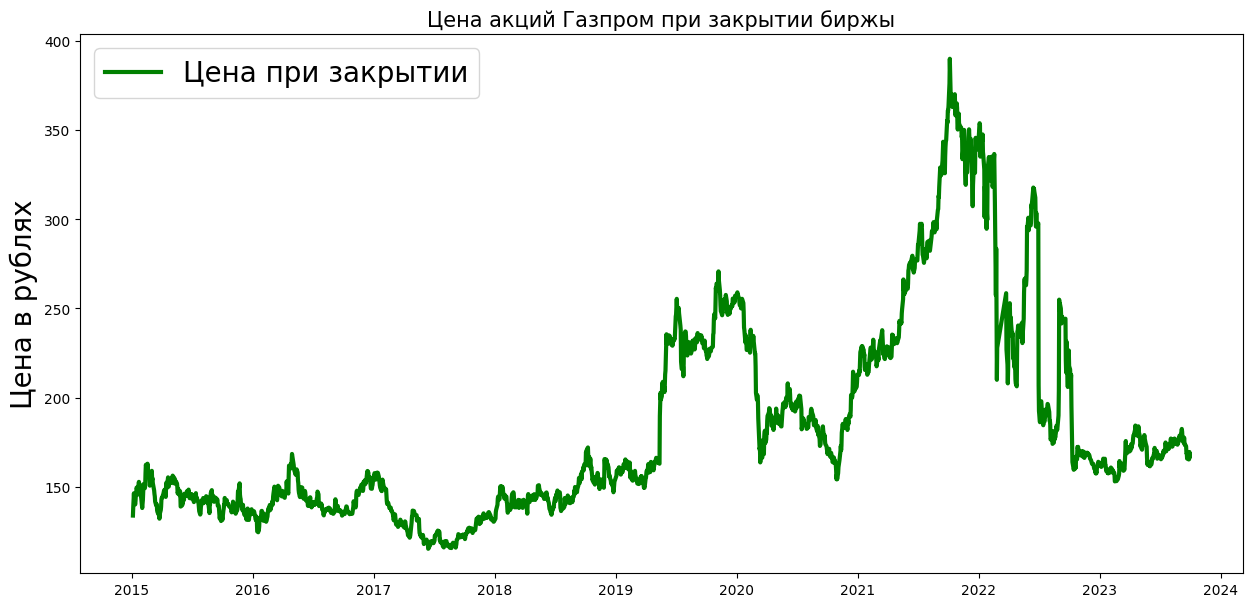

In [1734]:
# визуализируем данные по признаку Close
plt.figure(figsize=(15,7))
plt.plot(gzp_data['DATE'], # ось x
         gzp_data['CLOSE'], # ось y
         color="green", # цвет
         label="Цена при закрытии" # легенда
         )

plt.title('Цена акций Газпром при закрытии биржы', fontsize=15) # добавим заголовок
plt.ylabel('Цена в рублях') # подпись оси y
plt.legend() # выводим легенду

plt.show() # выводими график на экран

*Вывод: По графику мы видим, что наблюдалось два пика рост цен на акции Газпром: в 2019 и в 2021-2022 гг. Это скорее всего связано с внешнеэкономическими факторами и высокой прибылью компании в эти периоды. В данный момент цены снова стабилизировались до уровня первого пика.*

#### Проверим взаимосвязь цен на акции Газпром и цен на индекс РТС

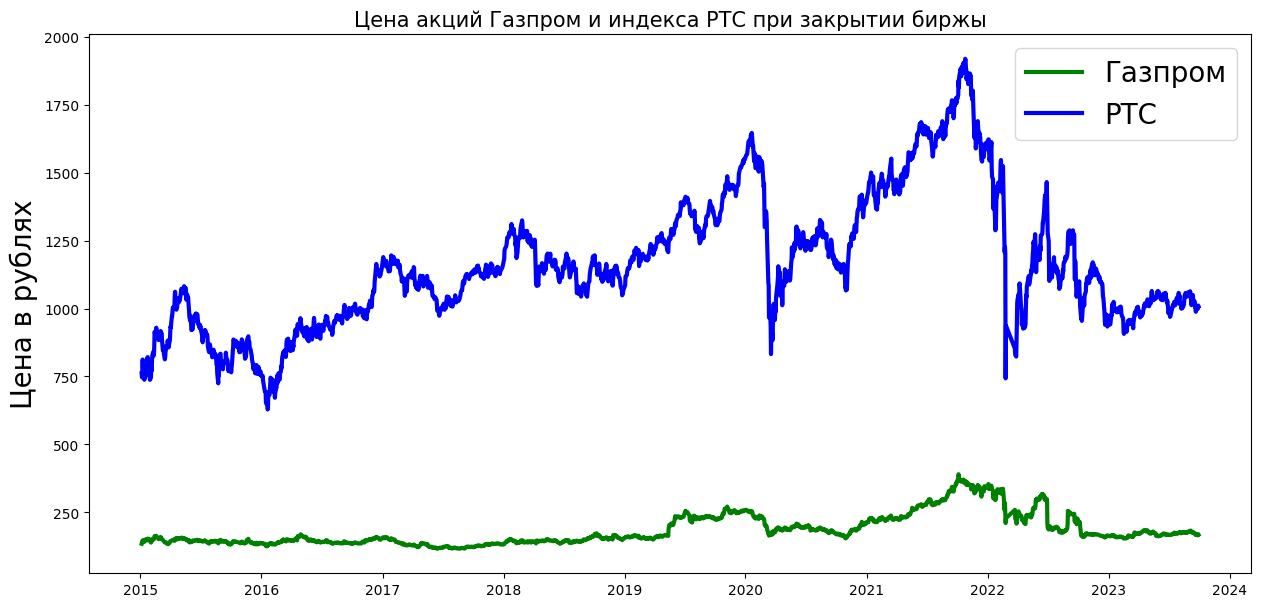

In [1735]:
# визуализируем данные по целевому признаку Close
plt.figure(figsize=(15,7))
plt.plot(gzp_data['DATE'], 
         gzp_data['CLOSE'], 
         color="green", 
         label="Газпром")

plt.plot(rts_data['DATE'], 
         rts_data['CLOSE'], 
         color="blue", 
         label="РТС") 
 
plt.title('Цена акций Газпром и индекса РТС при закрытии биржы', fontsize=15)
plt.ylabel('Цена в рублях')
plt.legend() 

plt.show()

*Вывод: по графику мы видим, что в целом данные коррелируются, наблюдается рост и падение на акции Газпром и индекс РТС в один период времени. В дальнейшем изменение цен на индекс РТС может быть сигналом при проведении сделок с акциями Газпром.*

#### Посмотрим на распределение объемов торгов акциями Газпром в анализируемый период времени

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


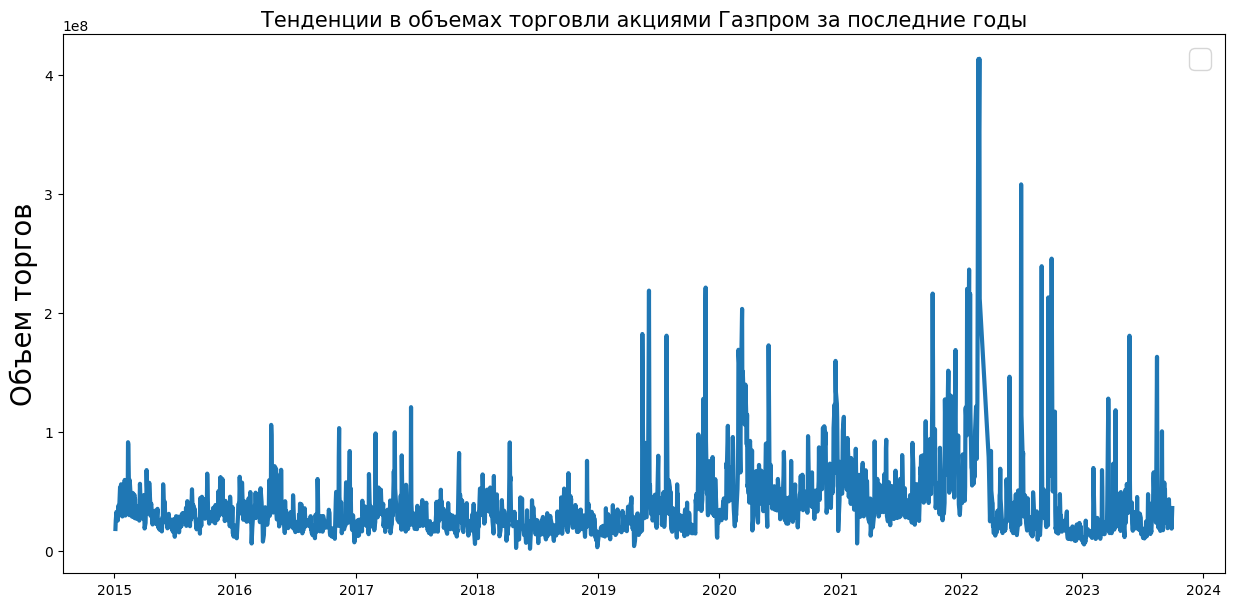

In [1736]:
plt.figure(figsize=(15,7))
plt.plot(gzp_data['DATE'], 
         gzp_data['VOLUME']) 
plt.title('Тенденции в объемах торговли акциями Газпром за последние годы', fontsize=15)
plt.ylabel('Объем торгов')
plt.legend() 

plt.show()

*Вывод: мы видим, что данный график визуально похож на график цен на акции Газпром. Здесь также можно выделить два пика:  2019 г. и 2021-2022 гг. Это говорит нам о том, что в моменты роста цен на акции, объем торгов также увеличивается.*

#### Проанализируем распределение основных признаков в наших данных

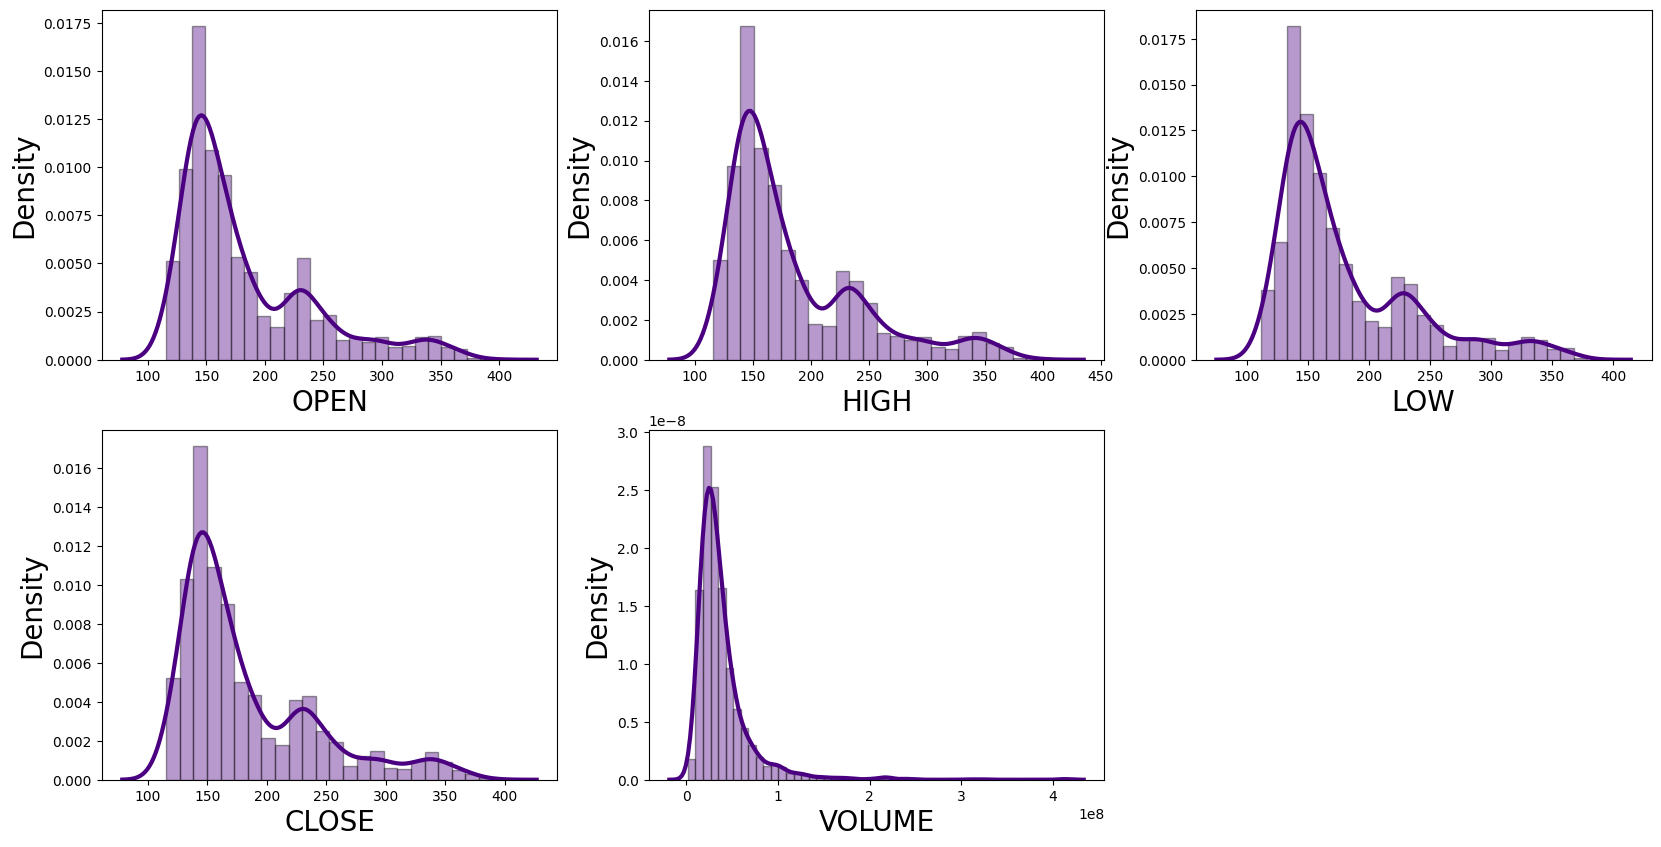

In [1737]:
# построим графики распределения непрерывной переменной
features = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.distplot(gzp_data[col], color='indigo')

plt.show()

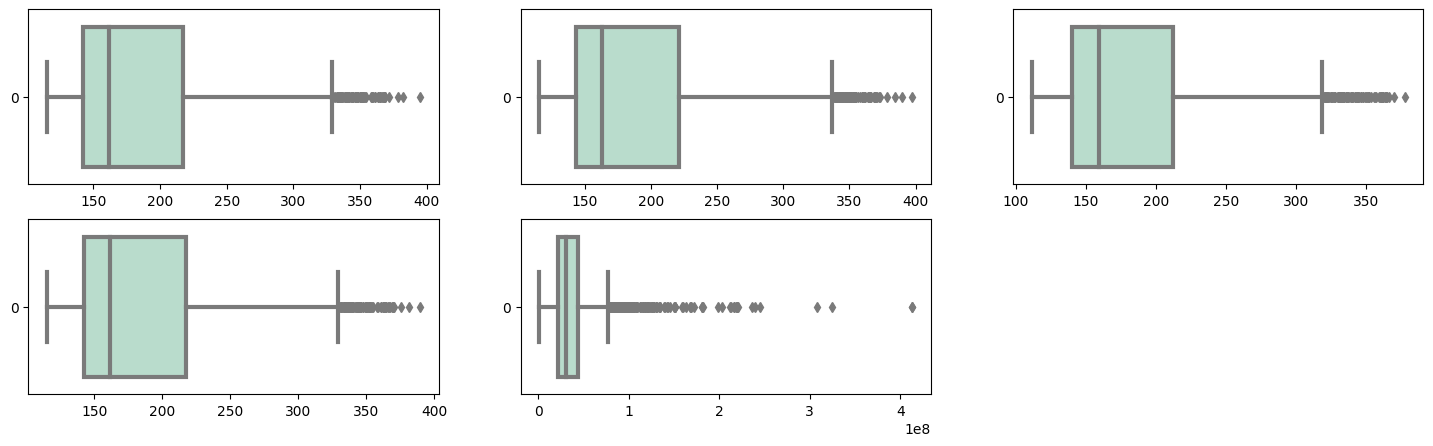

In [1738]:
# построим также бокс-плоты (ящики с усами)
plt.subplots(figsize=(18,5))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.boxplot(gzp_data[col], orient='h', palette='Pastel2')
plt.show()

*По графикам мы видим, что все распределения смещены в левую часть графика. Цена на акции Газпром выше 320-340 рублей за акцию можно считать выбросами в данных.* 

#### Построим графики, демонстрирующие распределение цен на акции Газпром по годам. Для этого предварительно посчитаем среднее по годам.

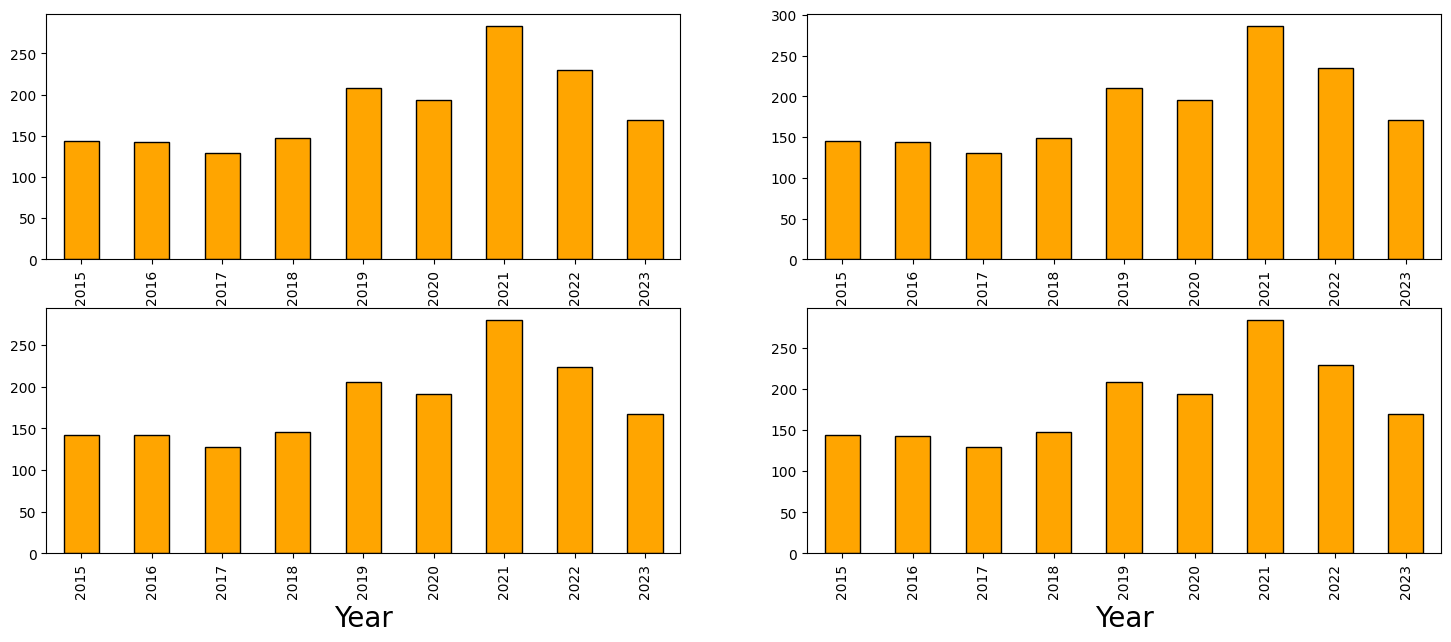

In [1739]:
# сгруппируем данные по годам и вычислим среднее
data_grouped = gzp_data.groupby('Year').mean()
plt.subplots(figsize=(18,7))
 
for i, col in enumerate(['OPEN', 'HIGH', 'LOW', 'CLOSE']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar(color='orange')
plt.show()

*Из графиков видно, что цены на акции Газпром росли до 2021 года, после 2021 года наблюдается снижение цен на акции. В целом также можно сказать, что в период с 2015 по 2018 год цены на акции Газпром стабильно держались в районе 140-150 рублей за акцию.*

#### Каждая компания по результатам своей работы публикует квартальные отчеты, которые помогают анализировать результаты деятельности компании. Посмотрим влияют ли квартальны результаты на цены акций. Квартал определяется как группа из 3 месяцев.

In [1740]:
# создадим признак, который показывает приходится ли месяц на конец квартала
gzp_data['Is_quarter_end'] = np.where(gzp_data['Month']%3==0,1,0)
gzp_data

DATE    OPEN    HIGH     LOW   CLOSE    VOLUME  Year  Month  Day  \
0    2015-01-05  129.60  133.95  129.15  133.95  18208740  2015      1    5   
1    2015-01-06  132.99  138.92  132.71  138.92  25270920  2015      1    6   
2    2015-01-08  140.06  147.50  140.00  146.46  32544100  2015      1    8   
3    2015-01-09  146.46  147.08  139.90  141.70  29501280  2015      1    9   
4    2015-01-12  141.37  143.44  139.72  140.22  25286750  2015      1   12   
...         ...     ...     ...     ...     ...       ...   ...    ...  ...   
2183 2023-09-25  166.71  168.05  165.20  165.87  24208290  2023      9   25   
2184 2023-09-26  165.83  165.85  163.51  165.36  26705860  2023      9   26   
2185 2023-09-27  165.75  166.92  165.11  165.53  18500170  2023      9   27   
2186 2023-09-28  165.81  169.77  165.31  169.58  28813860  2023      9   28   
2187 2023-09-29  169.18  170.39  166.60  167.09  35820090  2023      9   29   

       LEVEL  Is_quarter_end  
0      lower               0  
1      lower               0  
2      lower               0  
3      lower               0  
4      lower               0  
...      ...             ...  
2183  medium               1  
2184  medium               1  
2185  medium               1  
2186  medium               1  
2187  medium               1  

[2188 rows x 11 columns]

In [1741]:
# посчитаем среднее значение
gzp_data.groupby('Is_quarter_end').mean()

OPEN        HIGH         LOW       CLOSE        VOLUME  \
Is_quarter_end                                                                 
0               182.463820  184.663697  179.988827  182.483512  3.884341e+07   
1               184.143877  186.272055  181.732548  183.944986  3.838675e+07   

                       Year     Month        Day  
Is_quarter_end                                    
0               2018.884774  5.983539  16.045267  
1               2018.824658  7.487671  15.915068

Можно сделать следующие выводы:
- Цены выше в месяцы, приходящиеся на конец квартала, по сравнению с месяцами, не относящимися к концу квартала. Но это отличие незначительно
- Объем сделок ниже в месяцы, которые заканчиваются кварталом.

#### Проверим корреляцию наших признаков

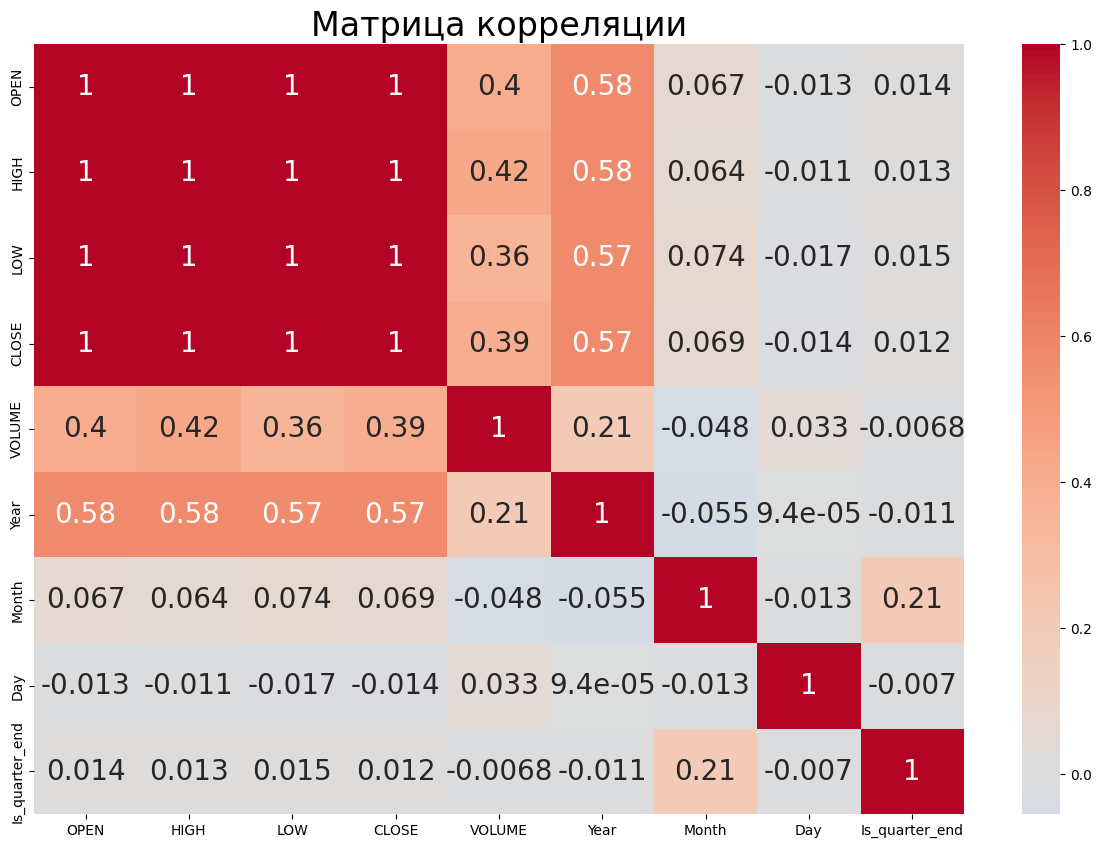

In [1742]:
# Создадим матрицу корреляции
correlation  = gzp_data.corr()
fig = plt.figure(figsize=(15, 10))
# Построим тепловую карту на основе матрицы корреляции
sns.heatmap(correlation, cmap='coolwarm',
            center=0, annot=True)
 
# Добавим заголовок
plt.title('Матрица корреляции')
 
# Выведем матрицу на экран
plt.show()

*Вывод: Видим, что существует очень сильная корреляционная зависимость между признаками OPEN, HIGH, LOW, CLOSE. Это вполне ожидаемо, т.к. данные признаки показывают изменение цены на акцию в пределях одного дня. В пределах одного дня цена сильно не меняется. В дальнейшем анализе будем использовать только признак CLOSE.*

#### Построим графики зависимости цен акций по годам

Text(0.5, 1.0, '2023 год')

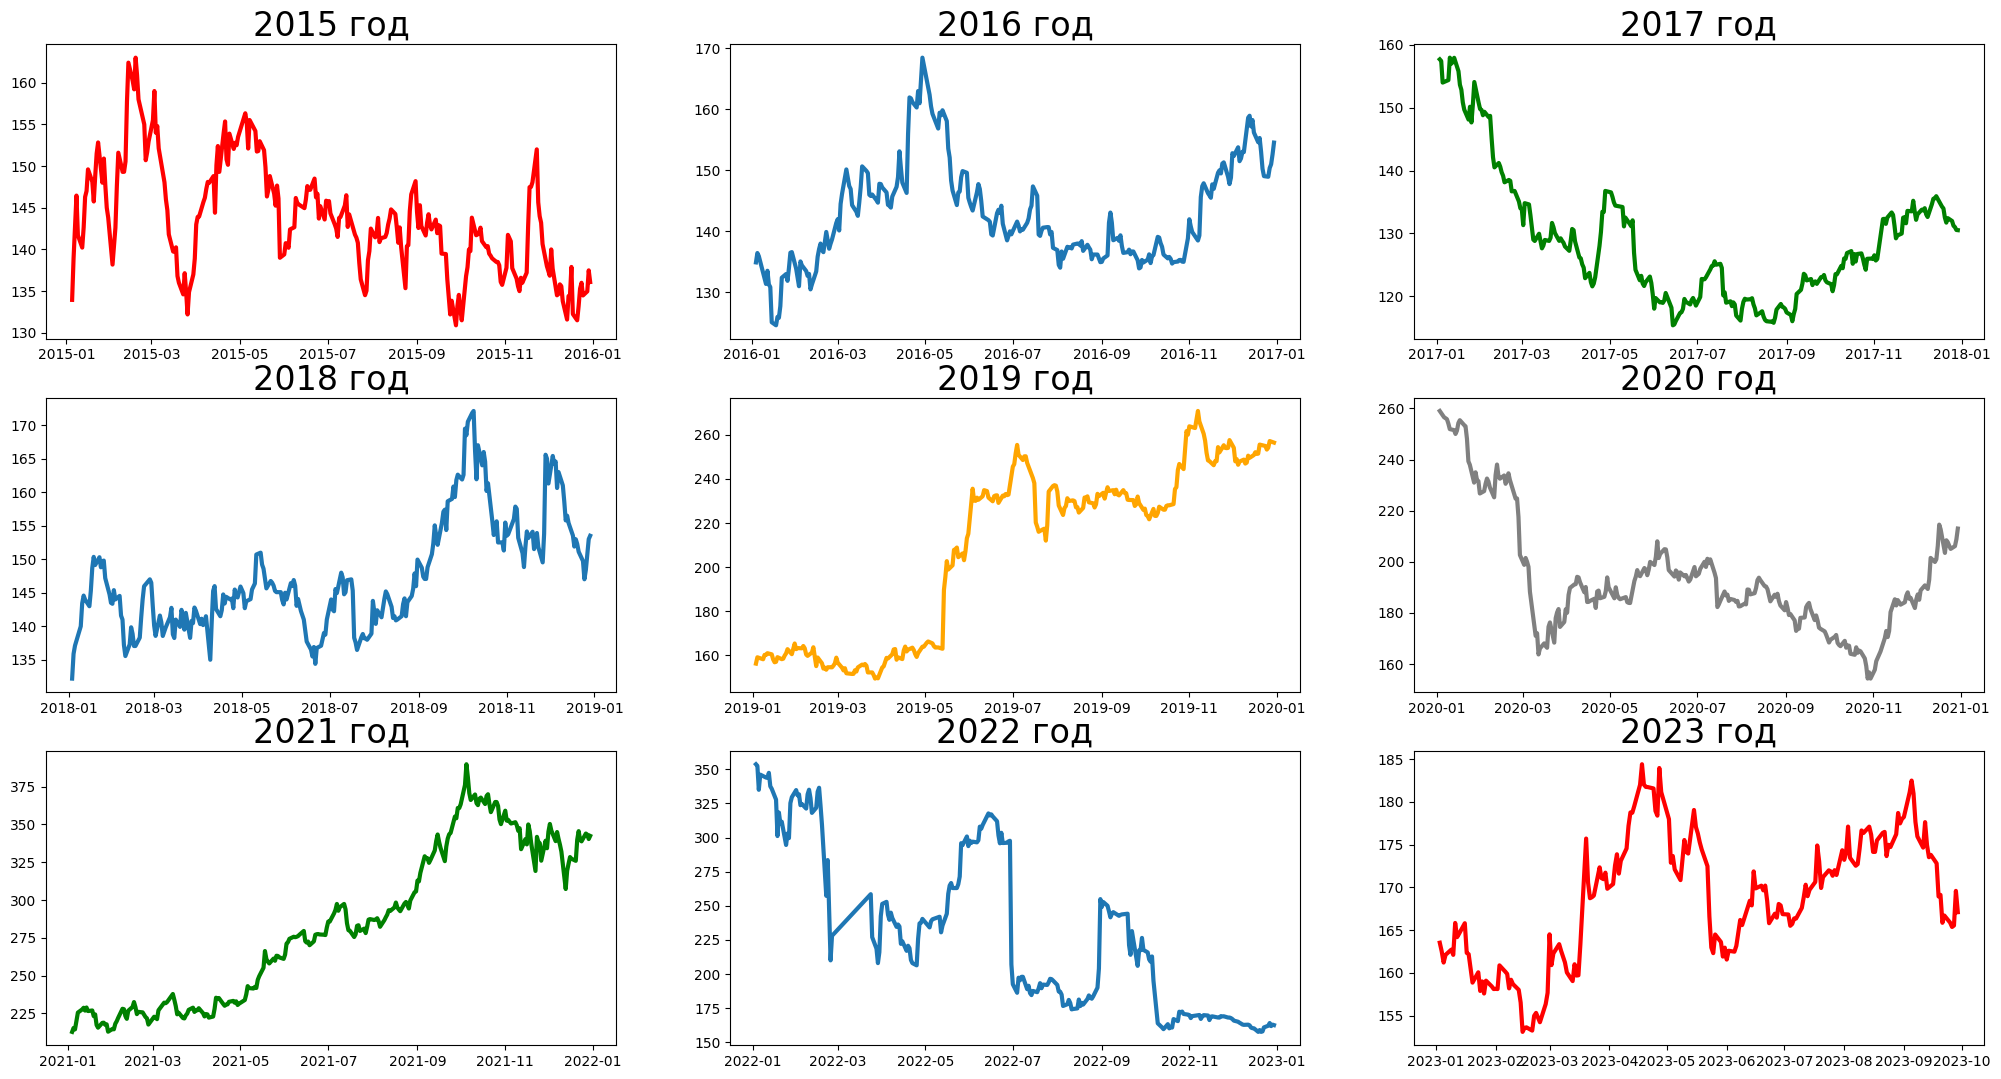

In [1743]:
# создадим новые датафреймы
df_2015 = gzp_data[gzp_data['Year'] == 2015]
df_2016 = gzp_data[gzp_data['Year'] == 2016]
df_2017 = gzp_data[gzp_data['Year'] == 2017]
df_2018 = gzp_data[gzp_data['Year'] == 2018]
df_2019 = gzp_data[gzp_data['Year'] == 2019]
df_2020 = gzp_data[gzp_data['Year'] == 2020]
df_2021 = gzp_data[gzp_data['Year'] == 2021]
df_2022 = gzp_data[gzp_data['Year'] == 2022]
df_2023 = gzp_data[gzp_data['Year'] == 2023]

# построимм график на 2015 год
plt.subplots(figsize=(25,13))
plt.subplot(3, 3, 1)
plt.plot(df_2015['DATE'], 
         df_2015['CLOSE'],
         color='red',
        )
plt.title('2015 год')

# построимм график на 2016 год
plt.subplot(3, 3, 2)
plt.plot(df_2016['DATE'], 
         df_2016['CLOSE'])
plt.title('2016 год') 

# построимм график на 2017 год
plt.subplot(3, 3, 3)
plt.plot(df_2017['DATE'], 
         df_2017['CLOSE'],
         color='green')
plt.title('2017 год') 

# построимм график на 2018 год
plt.subplot(3, 3, 4)
plt.plot(df_2018['DATE'], 
         df_2018['CLOSE'])
plt.title('2018 год') 

# построимм график на 2019 год
plt.subplot(3, 3, 5)
plt.plot(df_2019['DATE'], 
         df_2019['CLOSE'],
         color='orange')
plt.title('2019 год') 

# построимм график на 2020 год
plt.subplot(3, 3, 6)
plt.plot(df_2020['DATE'], 
         df_2020['CLOSE'],
         color='grey')
plt.title('2020 год') 

# построимм график на 2021 год
plt.subplot(3, 3, 7)
plt.plot(df_2021['DATE'], 
         df_2021['CLOSE'],
         color='green')
plt.title('2021 год') 

# построимм график на 2022 год
plt.subplot(3, 3, 8)
plt.plot(df_2022['DATE'], 
         df_2022['CLOSE'])
plt.title('2022 год') 

# построимм график на 2023 год
plt.subplot(3, 3, 9)
plt.plot(df_2023['DATE'], 
         df_2023['CLOSE'],
         color='red')
plt.title('2023 год') 

*Вывод: по графикам мы не можем выделить какую-то явную зависимость, например, что в начале года наблюдается рост цен на акции, а в конце падение. В каждый год наблюдается свой тренд, который зависит от внешнеэкономических факторов, новостного фона, показателями деятельности компании и многого другого.*

#### Посмотрим на все основные статистические показатели цен при закрытии биржы по годам

In [1744]:
stat = gzp_data.groupby('Year')['CLOSE'].describe()
var = gzp_data.groupby('Year')['CLOSE'].var()
median = gzp_data.groupby('Year')['CLOSE'].median()

# объединим таблицы stat и median
join = pd.concat([stat, median], axis=1)
join = join.rename(columns={'CLOSE': 'median'})

# объединим таблицы join и var
join = pd.concat([join, var], axis=1)
join = join.rename(columns={'CLOSE': 'var'})
display(join)

count        mean        std     min       25%      50%       75%  \
Year                                                                      
2015  250.0  143.497680   6.551625  130.90  138.9050  142.855  147.4925   
2016  252.0  142.792421   8.213609  124.60  136.5675  141.100  147.7500   
2017  252.0  128.882143  10.304190  115.35  121.4125  126.700  133.4475   
2018  254.0  147.411496   8.158632  132.20  141.5000  145.270  152.3375   
2019  252.0  208.331468  38.938810  149.49  161.6650  227.050  236.1850   
2020  250.0  193.466320  22.797398  154.28  181.1100  188.170  199.9975   
2021  255.0  283.237255  50.927454  212.71  230.2550  279.510  334.9000   
2022  234.0  228.907308  59.054804  157.59  172.8775  217.145  280.4825   
2023  189.0  168.814550   7.386990  153.09  162.5800  169.580  174.4300   

         max   median          var  
Year                                
2015  163.00  142.855    42.923795  
2016  168.47  141.100    67.463371  
2017  157.97  126.700   106.176325  
2018  172.11  145.270    66.563270  
2019  270.74  227.050  1516.230891  
2020  259.00  188.170   519.721376  
2021  389.82  279.510  2593.605611  
2022  353.73  217.145  3487.469908  
2023  184.39  169.580    54.567628

*Вывод:* 
- из таблицы видно, что максимальное значение цен на акции зафиксировано в 2021 году (389,82 руб.), минимальное - в 2017 году (115,35 руб.)
- также в 2021 году самые высокие статистические показатели (среднее и медианное значения), а в 2017 году самые низкие
- самая высокая дисперсия наблюдается в 2022 году

#### Посмотрим как изменяется цена на акции в течение дня.

Для этого создадим два новых признака: 
- Difference - показатель разницы цены акции в течение дня в рублях;
- Percent - разница между максимальной и минимальной ценой акции в процентах.

In [1745]:
gzp_data['Difference'] = gzp_data['HIGH'] - gzp_data['LOW']
gzp_data['Percent'] = (gzp_data['Difference'] / gzp_data['HIGH']) * 100
gzp_data.describe()

OPEN         HIGH          LOW        CLOSE        VOLUME  \
count  2188.000000  2188.000000  2188.000000  2188.000000  2.188000e+03   
mean    183.024351   185.200306   180.570599   182.971115  3.869105e+07   
std      57.483554    58.489229    56.194289    57.386876  3.151609e+07   
min     115.250000   115.750000   111.460000   115.350000  1.573550e+06   
25%     142.132500   143.630000   140.500000   142.397500  2.161332e+07   
50%     161.500000   163.165000   159.305000   161.290000  3.033514e+07   
75%     216.917500   221.227500   212.297500   217.320000  4.407002e+07   
max     394.980000   397.640000   378.030000   389.820000  4.135501e+08   

              Year        Month          Day  Is_quarter_end   Difference  \
count  2188.000000  2188.000000  2188.000000     2188.000000  2188.000000   
mean   2018.864717     6.485375    16.001828        0.333638     4.629707   
std       2.520148     3.390897     8.726028        0.471620     5.931001   
min    2015.000000     1.000000     1.000000        0.000000     0.590000   
25%    2017.000000     4.000000     8.750000        0.000000     2.290000   
50%    2019.000000     7.000000    16.000000        0.000000     3.280000   
75%    2021.000000     9.000000    24.000000        1.000000     5.012500   
max    2023.000000    12.000000    31.000000        1.000000   128.490000   

           Percent  
count  2188.000000  
mean      2.346394  
std       2.166119  
min       0.350794  
25%       1.411361  
50%       1.886902  
75%       2.643315  
max      50.384284

Из таблицы видно, что в данных есть дни, когда цена менялась в течение дня на 128,5 рублей (50%). Это очень большой показатель, который скорее можно отнести к выбросам в данных. Скорее здесь стоит ориентироваться на среднее изменение цены акции в течение дня, которое составляет 2,25 %.

Text(0.5, 1.0, 'Процент роста акций в течение дня')

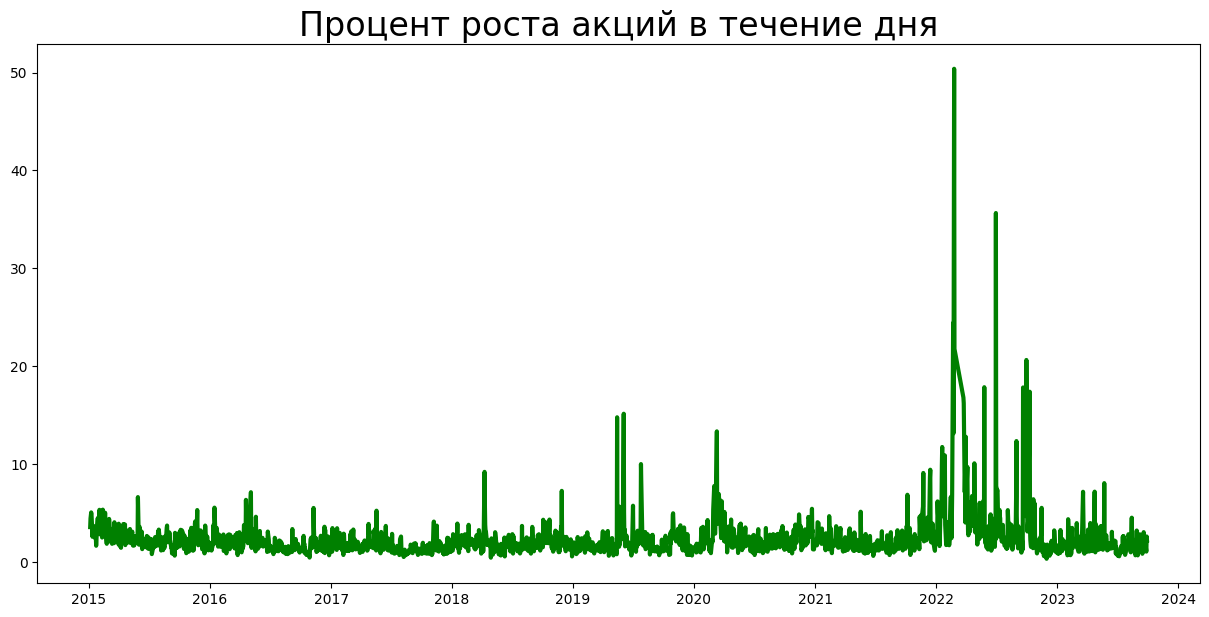

In [1746]:
# вызуализируем данные
plt.figure(figsize=(15,7))
plt.plot(gzp_data['DATE'], 
         gzp_data['Percent'],
         color='green')
plt.title('Процент роста акций в течение дня') 

*По графику видно, что рост акций в течение дня на 50% был в начале 2022 года. Также в этом году зафиксированы самые высокие скачки акций в течение дня, что связано с внешнеэкономическими факторами*

#### Сохраним полученные после разведывательного анализа данные в отдельный файл

In [1747]:
gzp_data.to_csv('data/processed_data.csv',index=False, header=True)

---

# <center> Часть 2. Машинное обучение <center>

#### Загрузим наши данные в новый датасет

In [1748]:
df = pd.read_csv("data/processed_data.csv",parse_dates=['DATE'], index_col=['DATE']) # считываем датасет и сразу переводим его в формат временного ряда
df

OPEN    HIGH     LOW   CLOSE    VOLUME  Year  Month  Day  \
DATE                                                                     
2015-01-05  129.60  133.95  129.15  133.95  18208740  2015      1    5   
2015-01-06  132.99  138.92  132.71  138.92  25270920  2015      1    6   
2015-01-08  140.06  147.50  140.00  146.46  32544100  2015      1    8   
2015-01-09  146.46  147.08  139.90  141.70  29501280  2015      1    9   
2015-01-12  141.37  143.44  139.72  140.22  25286750  2015      1   12   
...            ...     ...     ...     ...       ...   ...    ...  ...   
2023-09-25  166.71  168.05  165.20  165.87  24208290  2023      9   25   
2023-09-26  165.83  165.85  163.51  165.36  26705860  2023      9   26   
2023-09-27  165.75  166.92  165.11  165.53  18500170  2023      9   27   
2023-09-28  165.81  169.77  165.31  169.58  28813860  2023      9   28   
2023-09-29  169.18  170.39  166.60  167.09  35820090  2023      9   29   

             LEVEL  Is_quarter_end  Difference   Percent  
DATE                                                      
2015-01-05   lower               0        4.80  3.583427  
2015-01-06   lower               0        6.21  4.470199  
2015-01-08   lower               0        7.50  5.084746  
2015-01-09   lower               0        7.18  4.881697  
2015-01-12   lower               0        3.72  2.593419  
...            ...             ...         ...       ...  
2023-09-25  medium               1        2.85  1.695924  
2023-09-26  medium               1        2.34  1.410913  
2023-09-27  medium               1        1.81  1.084352  
2023-09-28  medium               1        4.46  2.627084  
2023-09-29  medium               1        3.79  2.224309  

[2188 rows x 12 columns]

#### Удалим лишние признаки

Для предсказания будем использовать только дату и цену акций при закрытии биржы

In [1749]:
gzp_data = df.drop(['OPEN', 'HIGH', 'LOW', 'VOLUME', 'Year', 'Month', 'Day', 'LEVEL', 'Is_quarter_end', 'Difference', 'Percent'], axis=1)
gzp_data

CLOSE
DATE              
2015-01-05  133.95
2015-01-06  138.92
2015-01-08  146.46
2015-01-09  141.70
2015-01-12  140.22
...            ...
2023-09-25  165.87
2023-09-26  165.36
2023-09-27  165.53
2023-09-28  169.58
2023-09-29  167.09

[2188 rows x 1 columns]

#### Повторно построим график цены акции при закрытии биржы по дням для полученного временного ряда

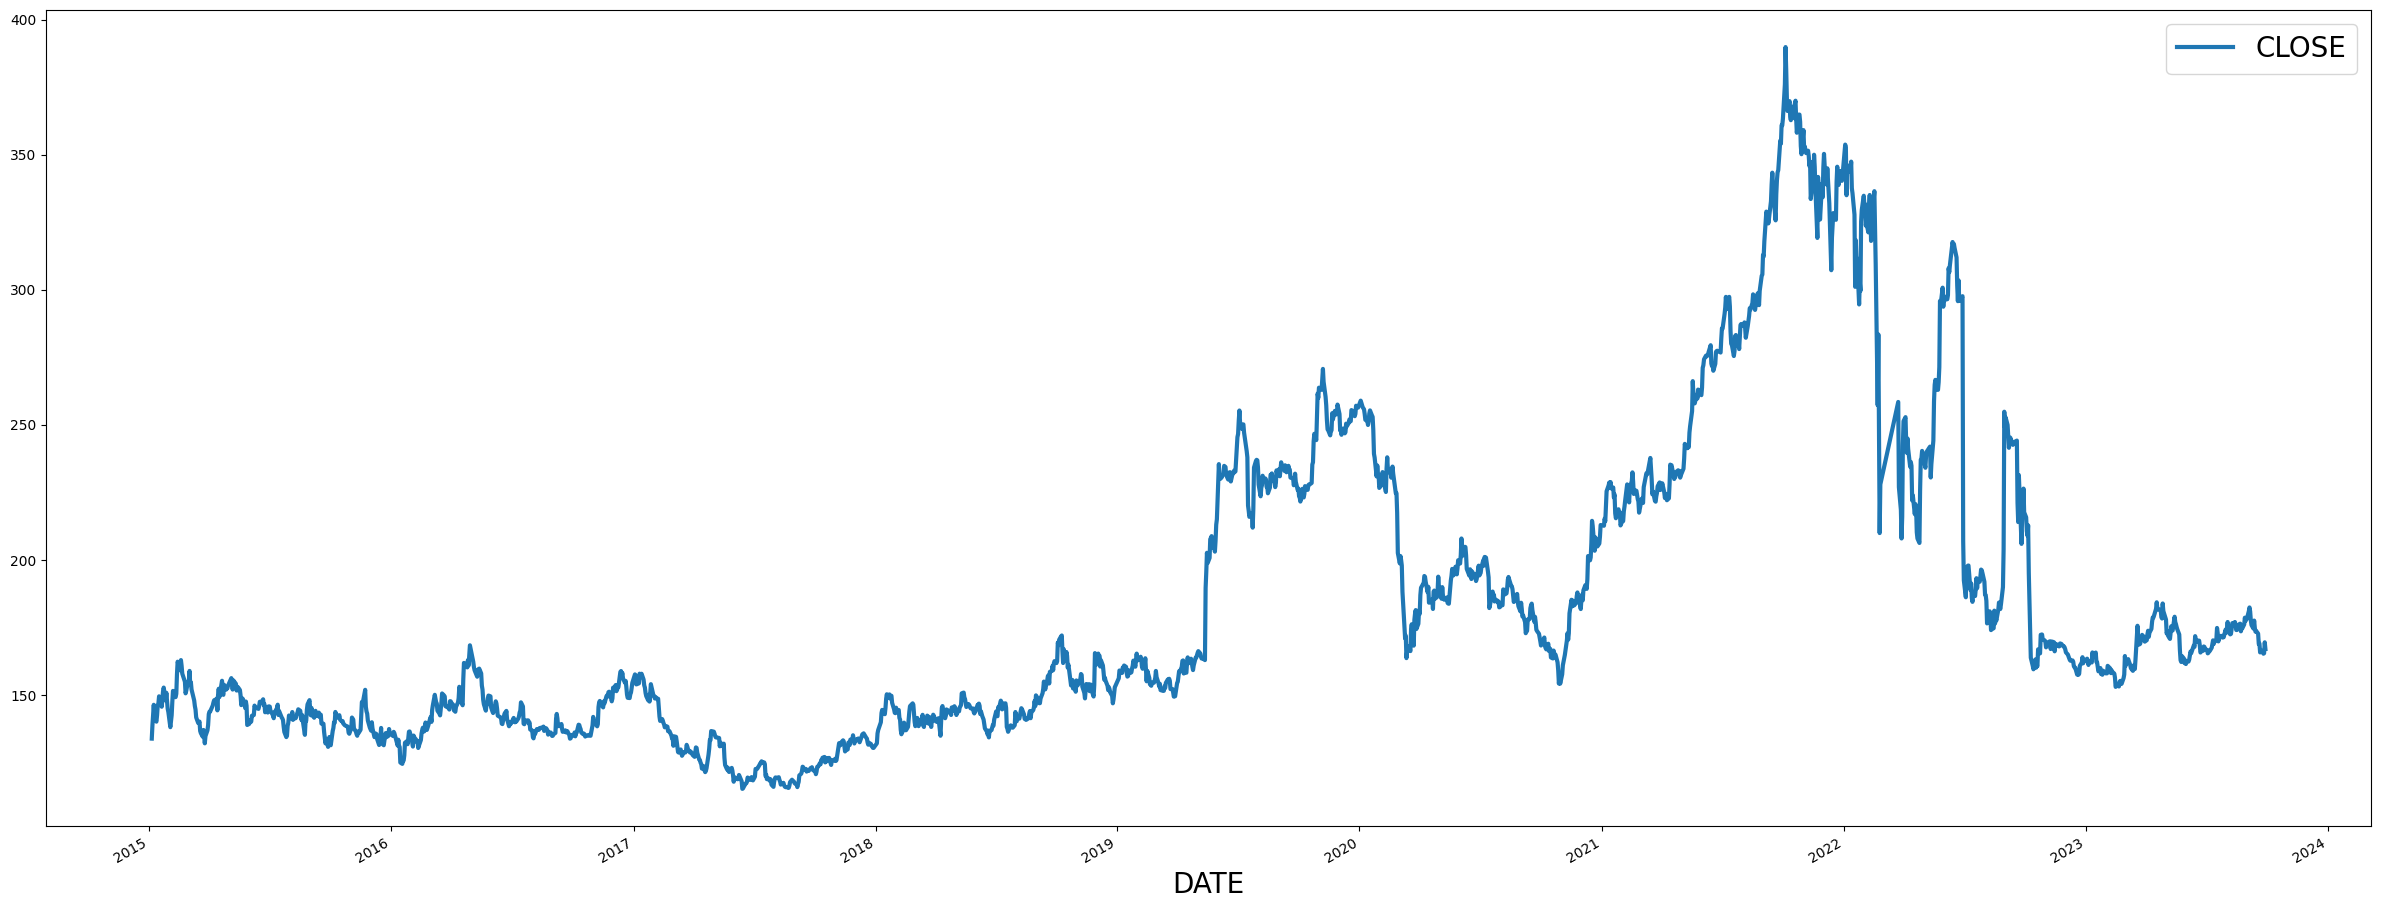

In [1750]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

gzp_data.plot()
plt.show()

Зададим частоту временного ряда. Зная, что в выходные и праздничные дни биржа не работает, поставим аргумент 'b' - business day. После проверим количество пропущенных значений во временном ряду.

In [1751]:
gzp_data = gzp_data.asfreq('b')
gzp_data.isnull().sum()

CLOSE    97
dtype: int64

Получается что у нас добавилось 97 новых дней, для которых не указаны значен цен на акции при закрытии биржы. Заполним пропущенные значения предыдущими.

In [1752]:
gzp_data.CLOSE = gzp_data.CLOSE.fillna(method='ffill')
gzp_data.isnull().sum() # повторно проверим количество пропущенных значений

CLOSE    0
dtype: int64

Разобьем временной ряд на тренировочный (по нему будем обучать модель) и тестовый (по нему будем осуществлять предсказания). Разделим в  пропорции 80/20.

In [1753]:
size = int(len(gzp_data)*0.8) # задаем длину

In [1754]:
train_df = gzp_data.iloc[:size]
test_df = gzp_data.iloc[size:]
train_df.shape, test_df.shape

((1824, 1), (456, 1))

Повторно построим графики по годам, но уже только для тренировочного временного ряда

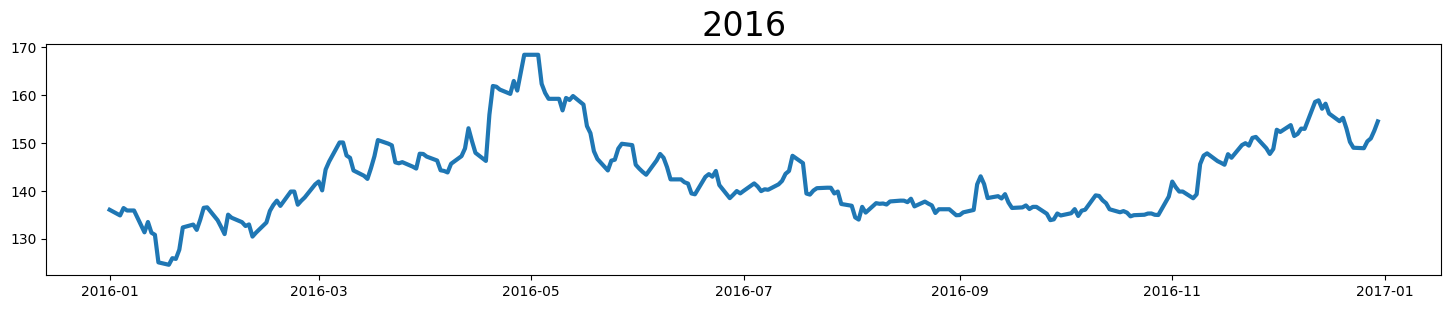

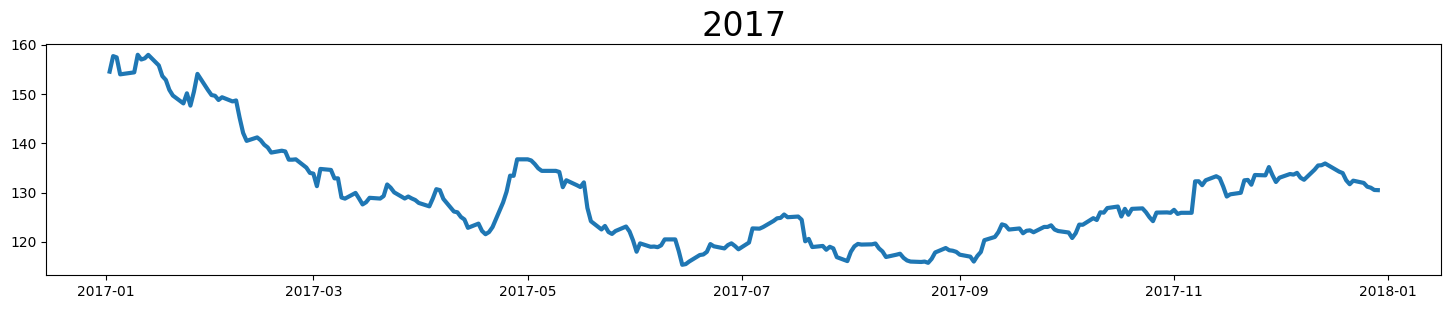

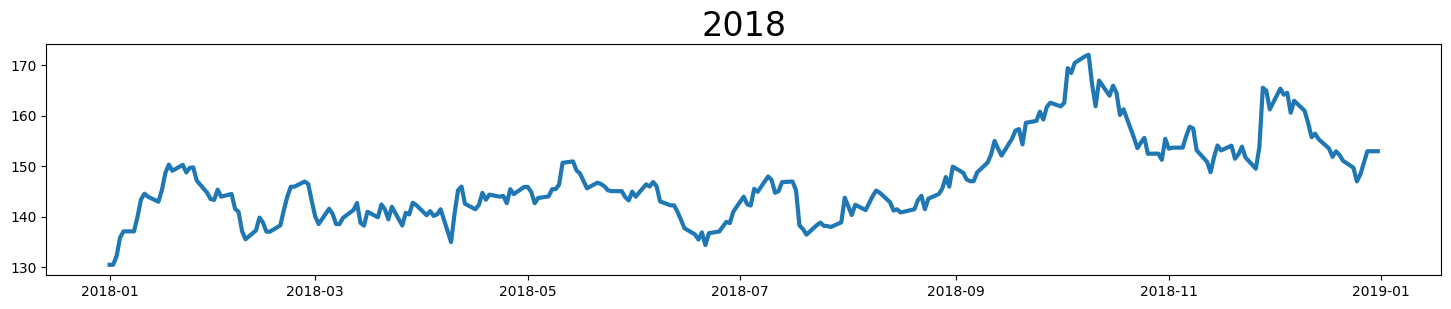

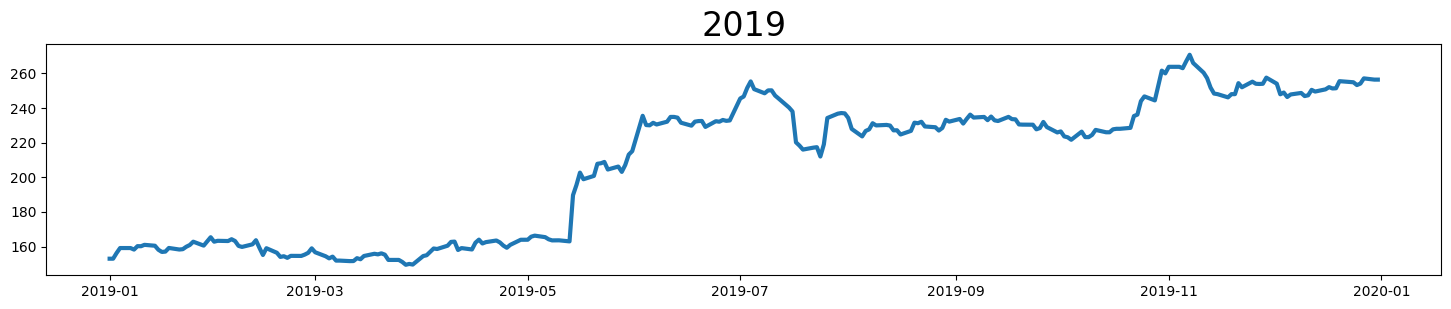

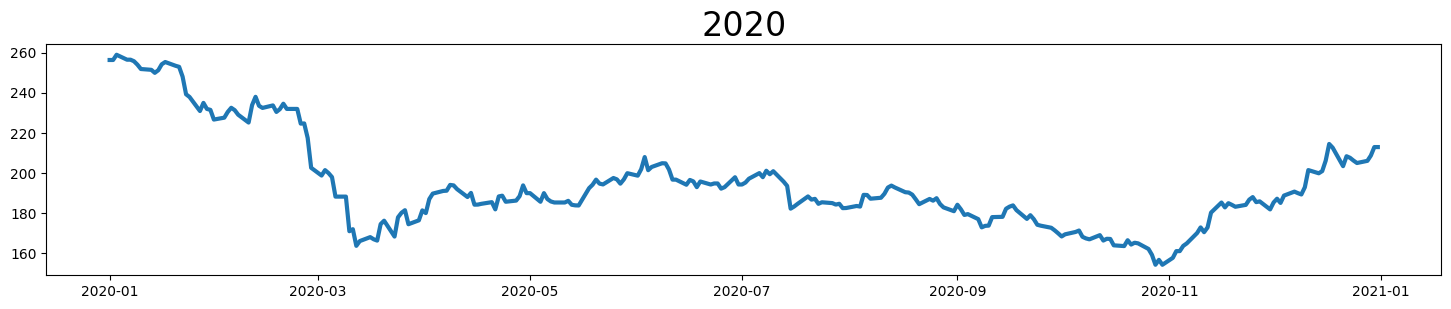

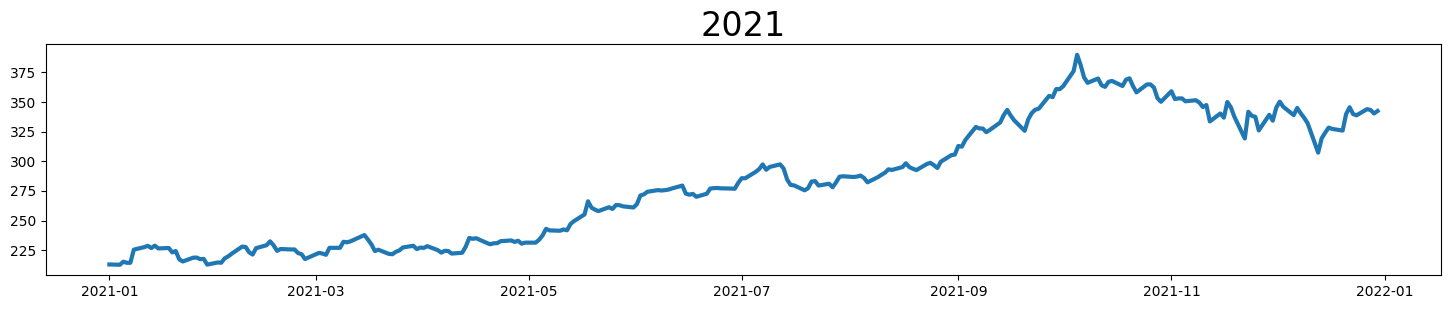

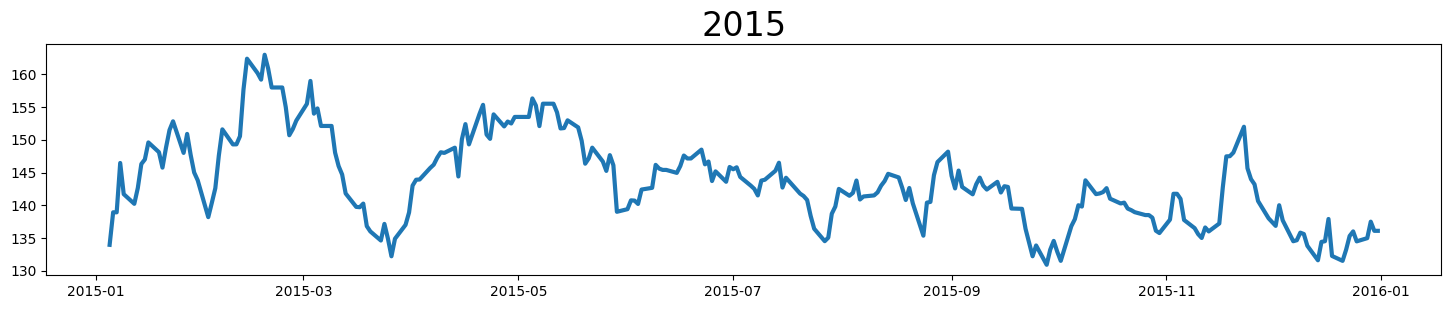

In [1755]:
plt.rcParams["figure.figsize"] = 18, 3

for year in set(train_df.index.year):
    plt.plot(train_df[["CLOSE"]].loc[train_df.index.year == year])
    plt.title(str(year), size=24)
    plt.show()

Построим графики сезонных компонент (тренд, сезонность, шум)

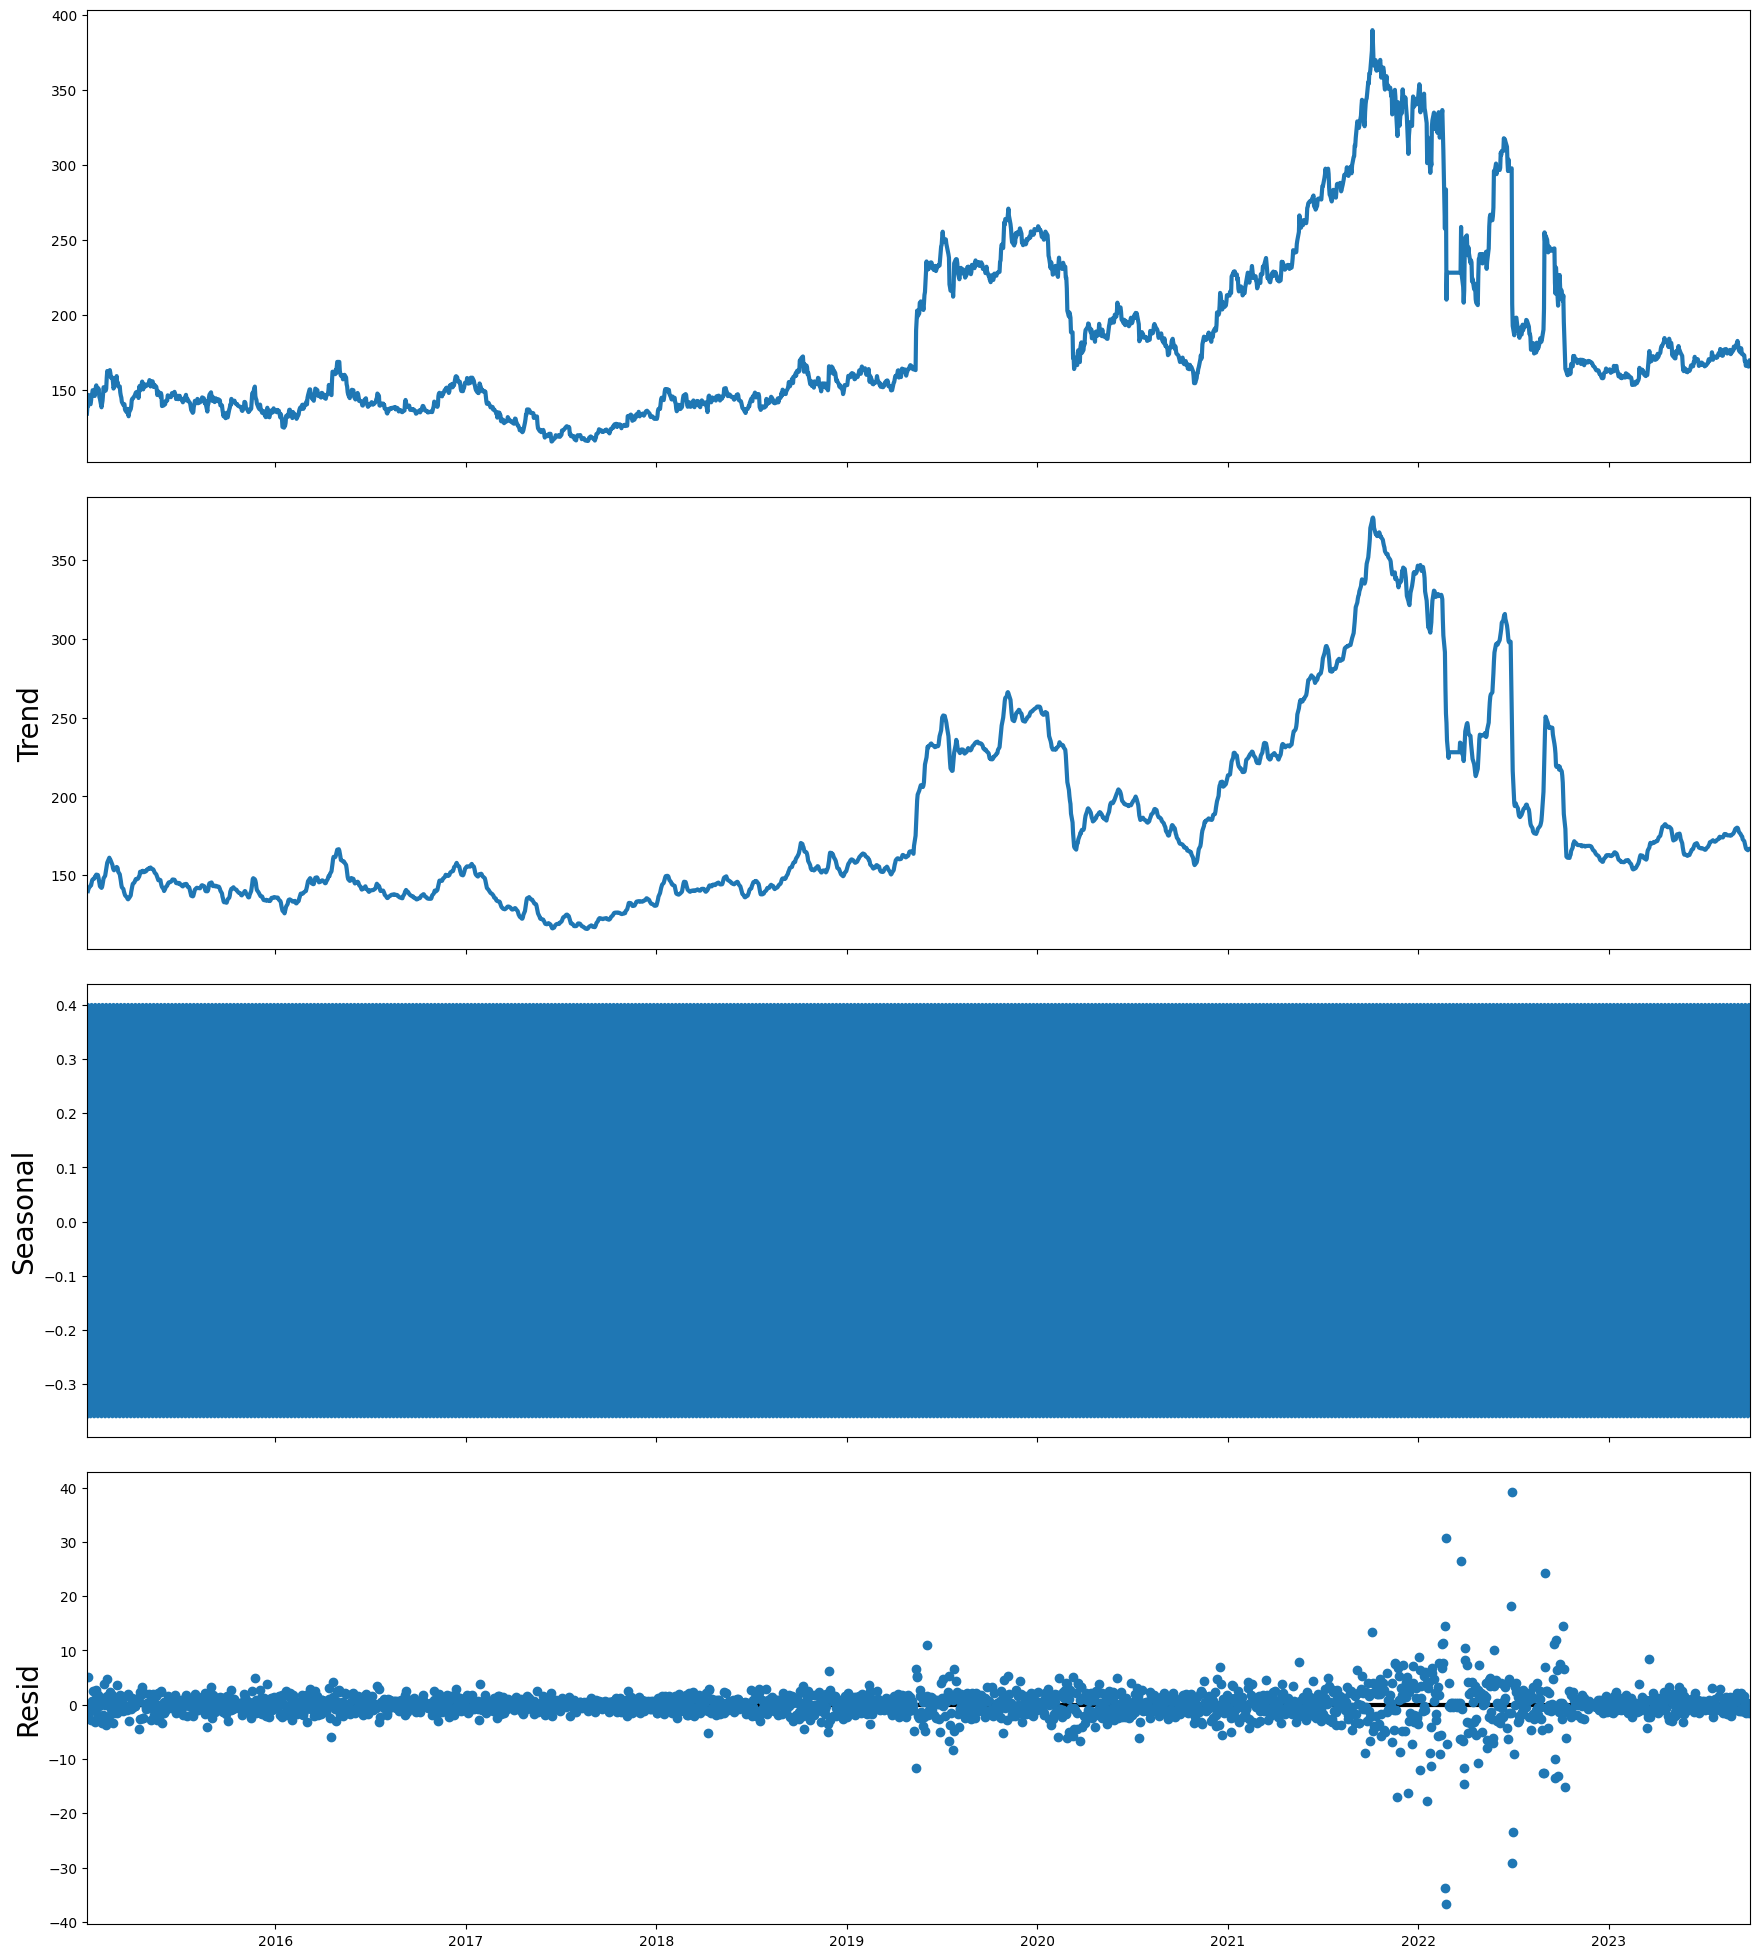

In [1756]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(gzp_data, model='additive')
result.plot()
plt.show()

*Видим, что тренд совпадает с основным графиком, сезонность требует отдельного рассмотрения, шум наблюдается в местах пиков*

Построим отдельно график сезонности

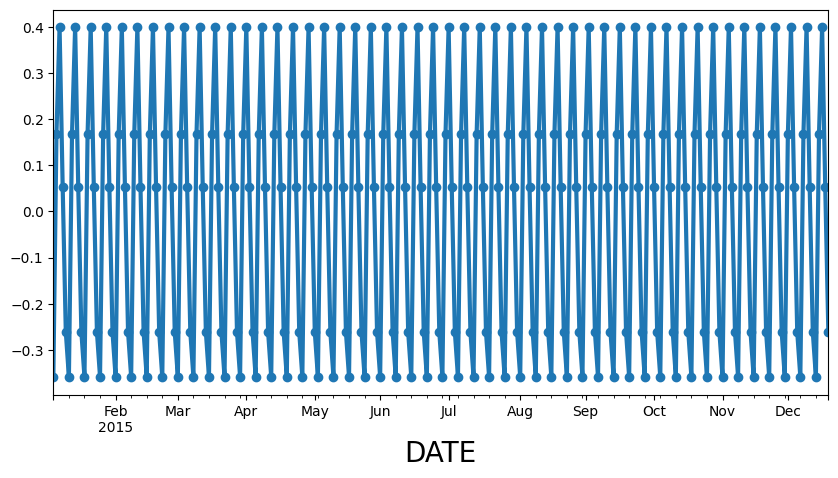

In [1757]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:250].plot(marker="o")
plt.show()

*По графику видно, что присутствует ярковыраженная сезонностьв 6 дней*

#### Скользящее среднее

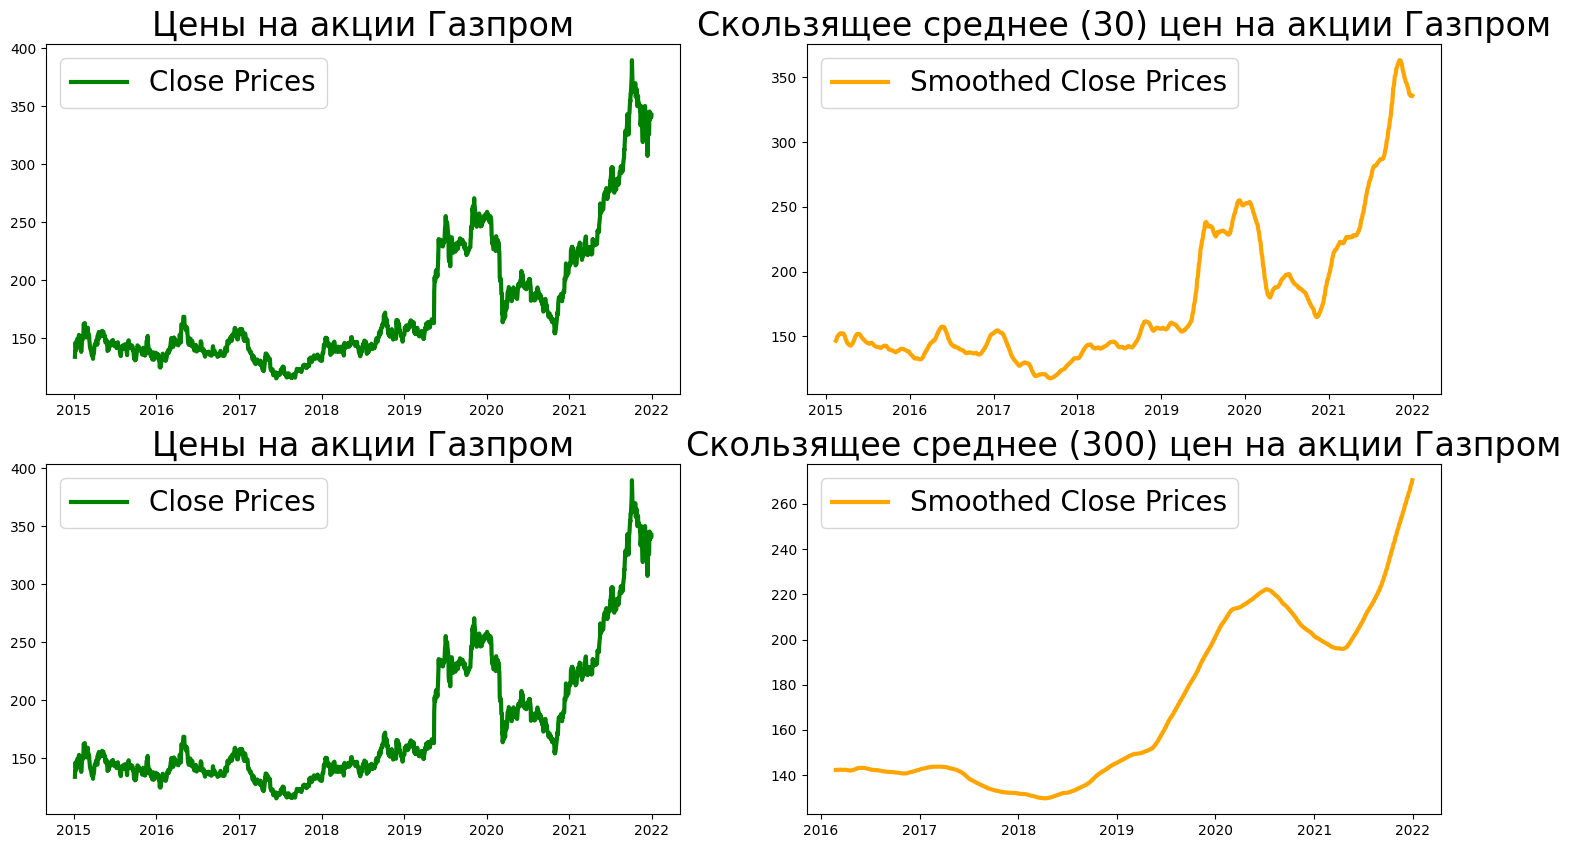

In [1758]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(train_df.CLOSE, color="green", label="Close Prices")
ax[0, 0].set_title("Цены на акции Газпром", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.CLOSE.rolling(window=30).mean(),
    color="orange",
    label="Smoothed Close Prices",
)

ax[0, 1].set_title("Скользящее среднее (30) цен на акции Газпром", size=24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train_df.CLOSE, color="green", label="Close Prices")
ax[1, 0].set_title("Цены на акции Газпром", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.CLOSE.rolling(window=300).mean(),
    color="orange",
    label="Smoothed Close Prices",
)

ax[1, 1].set_title("Скользящее среднее (300) цен на акции Газпром", size=24)
ax[1, 1].legend()

plt.show()

*По графику видно, что с окном в 30 дней скользящее среднее очень точно повторяет график, с окном в 300 дней хорошо улавливает общий тренд.*

#### Построим графики автокорреляции и частичной автокоррелиции

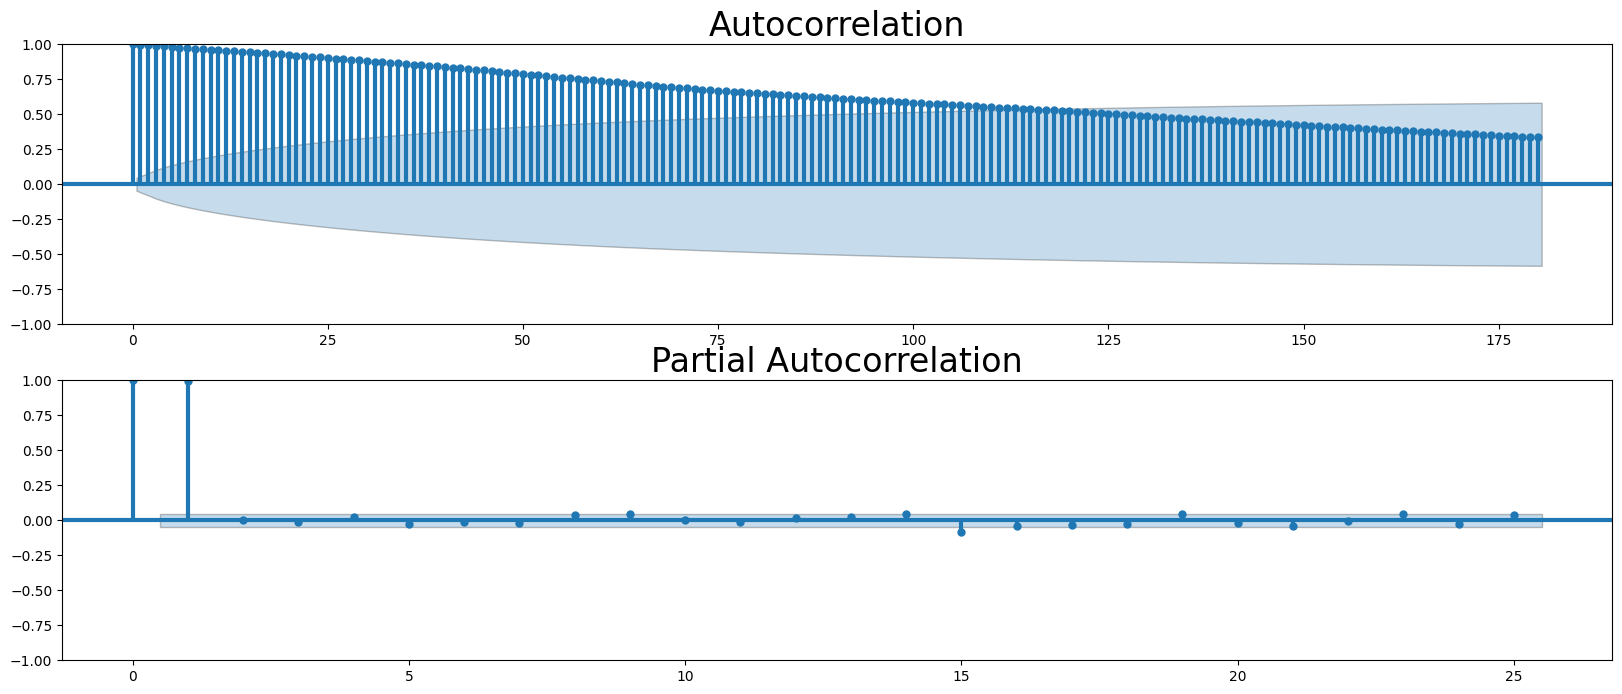

In [1759]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.values.squeeze(), lags=180, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df, lags=25, ax=ax2)

#### Тест Дики-Фуллера

In [1760]:
# напишем функцию для проведения теста Дики-Фуллера
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df) # проведем тест Дики-Фуллера для тренировочного ряда

adf:  0.03916901741310457
p-value:  0.9616539303824975
Critical values:  {'1%': -3.4339840952648695, '5%': -2.8631452508003057, '10%': -2.567624583142913}
есть единичные корни, ряд не стационарен


Тест показывает, что ряд не стационарен, требуется его дифференцировать

In [1761]:
otg1diff = train_df.diff(periods=1).dropna()
stat_test(otg1diff) 

adf:  -8.182429447134098
p-value:  8.064096329254731e-13
Critical values:  {'1%': -3.4339840952648695, '5%': -2.8631452508003057, '10%': -2.567624583142913}
единичных корней нет, ряд стационарен


*Ряд стал стационарным после первой дифференциации*

#### Повторно построим графики автокорреляции и частичной автокорреляции

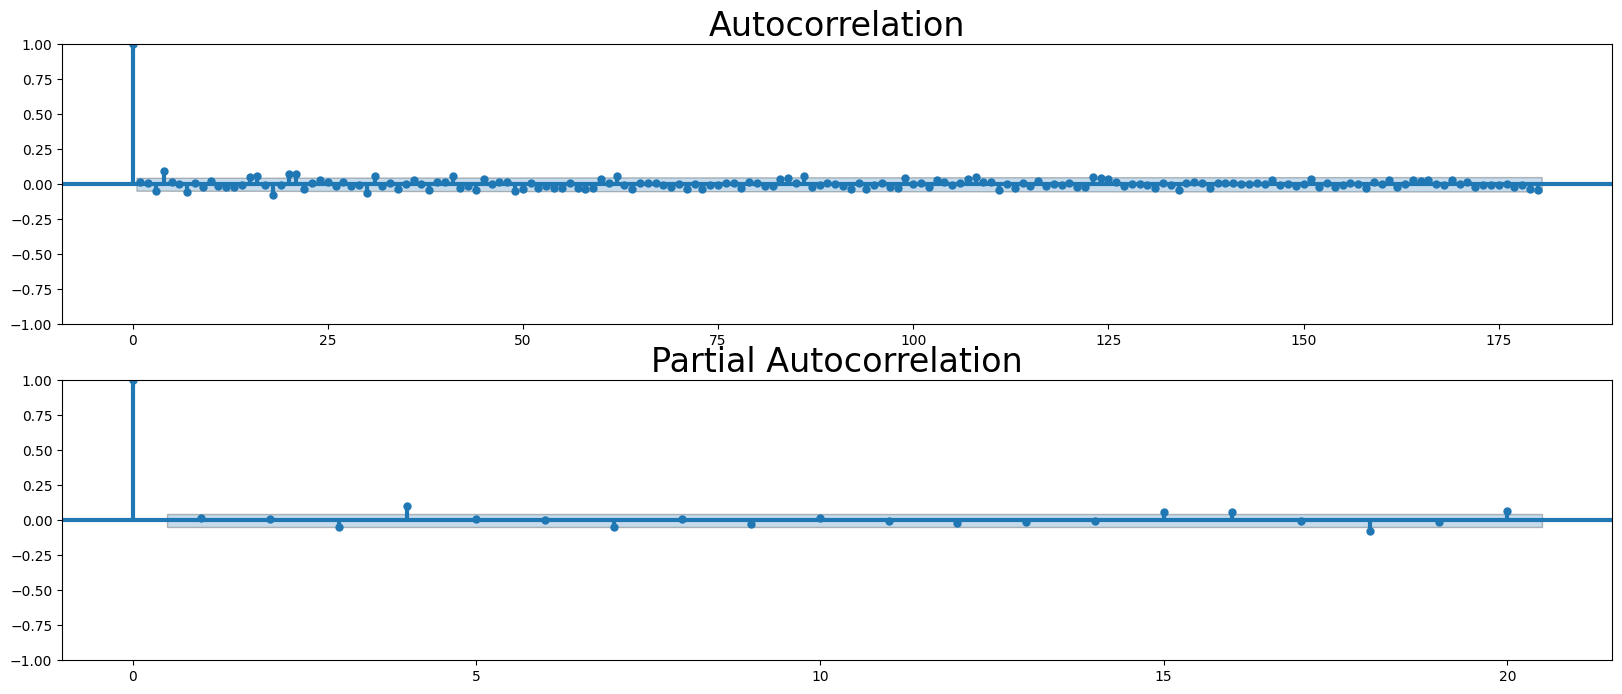

In [1762]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otg1diff.values.squeeze(), lags=180, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otg1diff, lags=20, ax=ax2, method=('ols'))

*График частичной автокорреляции показывает, что все значения после 0 уже незначительны (все в районе 0), в этом случае принимаем p = 1.*

#### Модель авторегрессии

In [1763]:
# построимм простую модель ааторегрессии
ar_model = AutoReg(train_df, lags=0).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train_df), end=(len(train_df)), dynamic=False)

                            AutoReg Model Results                             
Dep. Variable:                  CLOSE   No. Observations:                 1824
Model:                     AutoReg(0)   Log Likelihood               -9964.305
Method:               Conditional MLE   S.D. of innovations             57.051
Date:                Tue, 31 Oct 2023   AIC                          19932.611
Time:                        18:33:38   BIC                          19943.628
Sample:                    01-05-2015   HQIC                         19936.675
                         - 12-30-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        178.2158      1.336    133.412      0.000     175.598     180.834


*Это простая модель, которая не подгодит для предсказания нестационнарного временного ряда.*

#### Экспоненциальное сглаживание

In [1764]:
# построим модель экспоненциального сглаживания и обучим ее
ses = SimpleExpSmoothing(train_df)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
exp_pred = model.forecast(5)
print(exp_pred)

2021-12-31    342.015551
2022-01-03    342.015551
2022-01-04    342.015551
2022-01-05    342.015551
2022-01-06    342.015551
Freq: B, dtype: float64


*Вывод: данный тип предсказаний не может использоваться в  нашем случае, т.к. не дает предсказания в долгосроке и хорошо работает только на 1 день вперед.*

#### Предсказания с помощью AutoARIMA

In [1765]:
# определим модель с наилучшими параметрами
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=6,
    test="adf",
    error_action="ignore",
    trace=True
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=10562.615, Time=1.00 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=10068.395, Time=0.48 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=0.94 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=10561.426, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=9911.860, Time=0.48 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=2.00 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=9911.657, Time=0.35 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=10068.860, Time=0.24 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,1)(2,1,0)[6]             : AIC=9911.732, Time=0.37 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=9913.473, Time=0.77 sec
 ARIMA(0,1,0)(2,1,0)[6] intercept   : AIC=9913.656, Time=0.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1824
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 6)   Log Likelihood               -4952.828
Date:                           Tue, 31 Oct 2023   AIC                           9911.657
Time:                                   18:33:51   BIC                           9928.171
Sample:                               01-05-2015   HQIC                          9917.750
                                    - 12-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6       -0.6336      0.013    -50.301      0.000      -0.658      -0.609
ar.S.L12      -0.2980      0.013    -22.559      0.000      -0.324      -0.272
sigma2        13.6299      0.200     68.261      0.000      13.239      14.021
===================================================================================
Ljung-Box (L1) (Q):                   1.81   Jarque-Bera (JB):              5314.76
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               3.92   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

*AUTO ARIMA показывает, что наилучшие параметры для модели (0, 1, 0) и (2, 1, 0), сезонность равна 6. При данных значениях коэффициент AIC минимален. Обучим модель на данных параметрах.*

In [1766]:
model = SARIMAX(
    train_df["CLOSE"].dropna(), order=(0, 1, 0), seasonal_order=(2, 1, 0, 6))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             CLOSE   No. Observations:                 1824
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 6)   Log Likelihood               -4952.828
Date:                           Tue, 31 Oct 2023   AIC                           9911.657
Time:                                   18:33:51   BIC                           9928.171
Sample:                               01-05-2015   HQIC                          9917.750
                                    - 12-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6       -0.6336      0.013    -50.301      0.000      -0.658      -0.609
ar.S.L12      -0.2980      0.013    -22.559      0.000      -0.324      -0.272
sigma2        13.6299      0.200     68.261      0.000      13.239      14.021
===================================================================================
Ljung-Box (L1) (Q):                   1.81   Jarque-Bera (JB):              5314.76
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               3.92   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Проведем диагностику модели

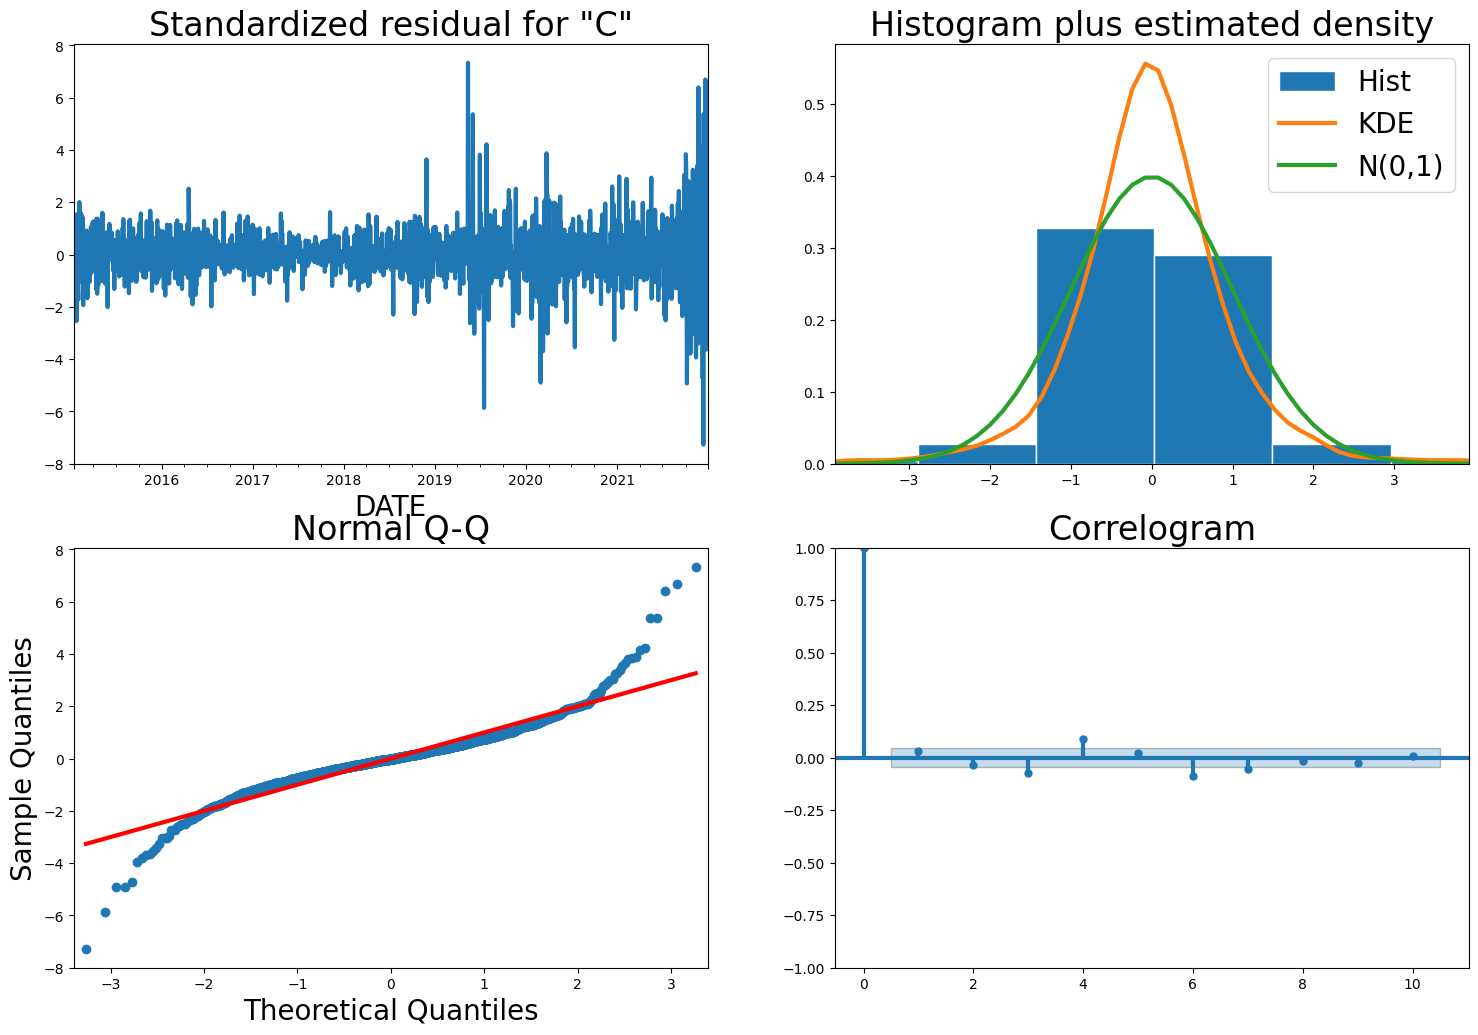

In [1767]:
model_fit.plot_diagnostics(figsize=(18, 12))
plt.show()

*Видим, что данные распределены ненормально.*

Делаем предсказание и выводим результаты на график

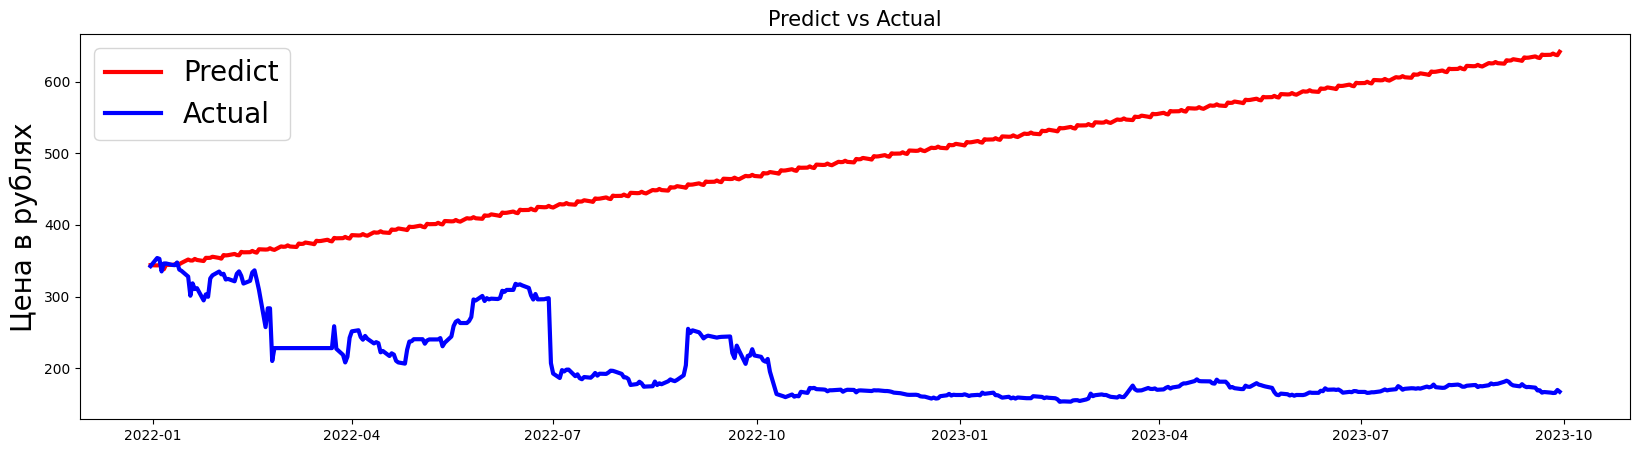

In [1768]:
start_date = '2021-12-31'
end_date = '2023-09-29'

df_pred = model_fit.predict(start=start_date, end=end_date)

plt.figure(figsize=(20,5))
plt.plot(df_pred, color="red", label="Predict")

plt.plot(test_df, color="blue", label="Actual") 

plt.title('Predict vs Actual', fontsize=15)
plt.ylabel('Цена в рублях')
plt.legend() 

plt.show()

*По графику видим, что модель неверно уловила общий тренд: модель предсказывает рост акций, тогда как в реальности произошло их падение.*

Посчитаем метрики MAE, MSE и MAPE для сравнения моделей

In [1769]:
mae = mean_absolute_error(test_df, df_pred)
print('MAE: %.3f' % mae)

MAE: 286.804


In [1770]:
np.sqrt(mean_squared_error(test_df, df_pred))

315.2114756814166

In [1771]:
print(f"Results MAPE: {mean_absolute_percentage_error(test_df, df_pred)*100:.1f}%")

Results MAPE: 161.0%


Такая большая ошибка в обучении может быть связана с тем, что тестовые данные начинаются на самом пике цен за акции Газпром за весь период. Посмотрим на предсказания модели, в которой обучающий набор данных включает падение цен на акции Газпром после данного пика. Для этого разделим тренировочный и тестовый ряд в соотношении 90/10.

In [1772]:
# для теста возьмем только 10% данных, на всех остальных данных будем нашу модель обучать
size = int(len(gzp_data)*0.9)
train_df = gzp_data.iloc[:size]
test_df = gzp_data.iloc[size:]
train_df.shape, test_df.shape
test_df

CLOSE
DATE              
2022-11-16  168.76
2022-11-17  168.99
2022-11-18  168.79
2022-11-21  168.13
2022-11-22  168.08
...            ...
2023-09-25  165.87
2023-09-26  165.36
2023-09-27  165.53
2023-09-28  169.58
2023-09-29  167.09

[228 rows x 1 columns]

In [1773]:
# повторно подберем модель с наилучшими параметрами
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=6,
    test="adf",
    error_action="ignore",
    trace=True
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=inf, Time=2.07 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=13728.965, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=13264.709, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=0.93 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=13730.943, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=13040.837, Time=0.50 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=1.63 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=1.19 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=13038.850, Time=0.35 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=13262.730, Time=0.20 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=inf, Time=1.51 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,1)(2,1,0)[6]             : AIC=13040.836, Time=0.47 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=3.28 sec
 ARIMA(0,1,0)(2,1,0)[6] intercept   : AIC=13040.848, Time=0.7

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2052
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 6)   Log Likelihood               -6516.425
Date:                           Tue, 31 Oct 2023   AIC                          13038.850
Time:                                   18:34:08   BIC                          13055.719
Sample:                               01-05-2015   HQIC                         13045.037
                                    - 11-15-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6       -0.5986      0.007    -89.513      0.000      -0.612      -0.586
ar.S.L12      -0.3230      0.007    -47.912      0.000      -0.336      -0.310
sigma2        34.2550      0.208    164.977      0.000      33.848      34.662
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            243897.85
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              14.08   Skew:                            -2.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

*AUTO ARIMA снова показывает, что наилучшие параметры для модели (0, 1, 0) и (2, 1, 0), сезонность равна 6. При данных значениях коэффициент AIC минимален. Обучим модель на данных параметрах.*

In [1774]:
model2 = SARIMAX(
    train_df["CLOSE"].dropna(), order=(0, 1, 0), seasonal_order=(2, 1, 0, 6))
model2_fit = model2.fit()
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             CLOSE   No. Observations:                 2052
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 6)   Log Likelihood               -6516.425
Date:                           Tue, 31 Oct 2023   AIC                          13038.850
Time:                                   18:34:08   BIC                          13055.719
Sample:                               01-05-2015   HQIC                         13045.037
                                    - 11-15-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6       -0.5986      0.007    -89.513      0.000      -0.612      -0.586
ar.S.L12      -0.3230      0.007    -47.912      0.000      -0.336      -0.310
sigma2        34.2550      0.208    164.977      0.000      33.848      34.662
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            243897.85
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              14.08   Skew:                            -2.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Проведем диагностику модели

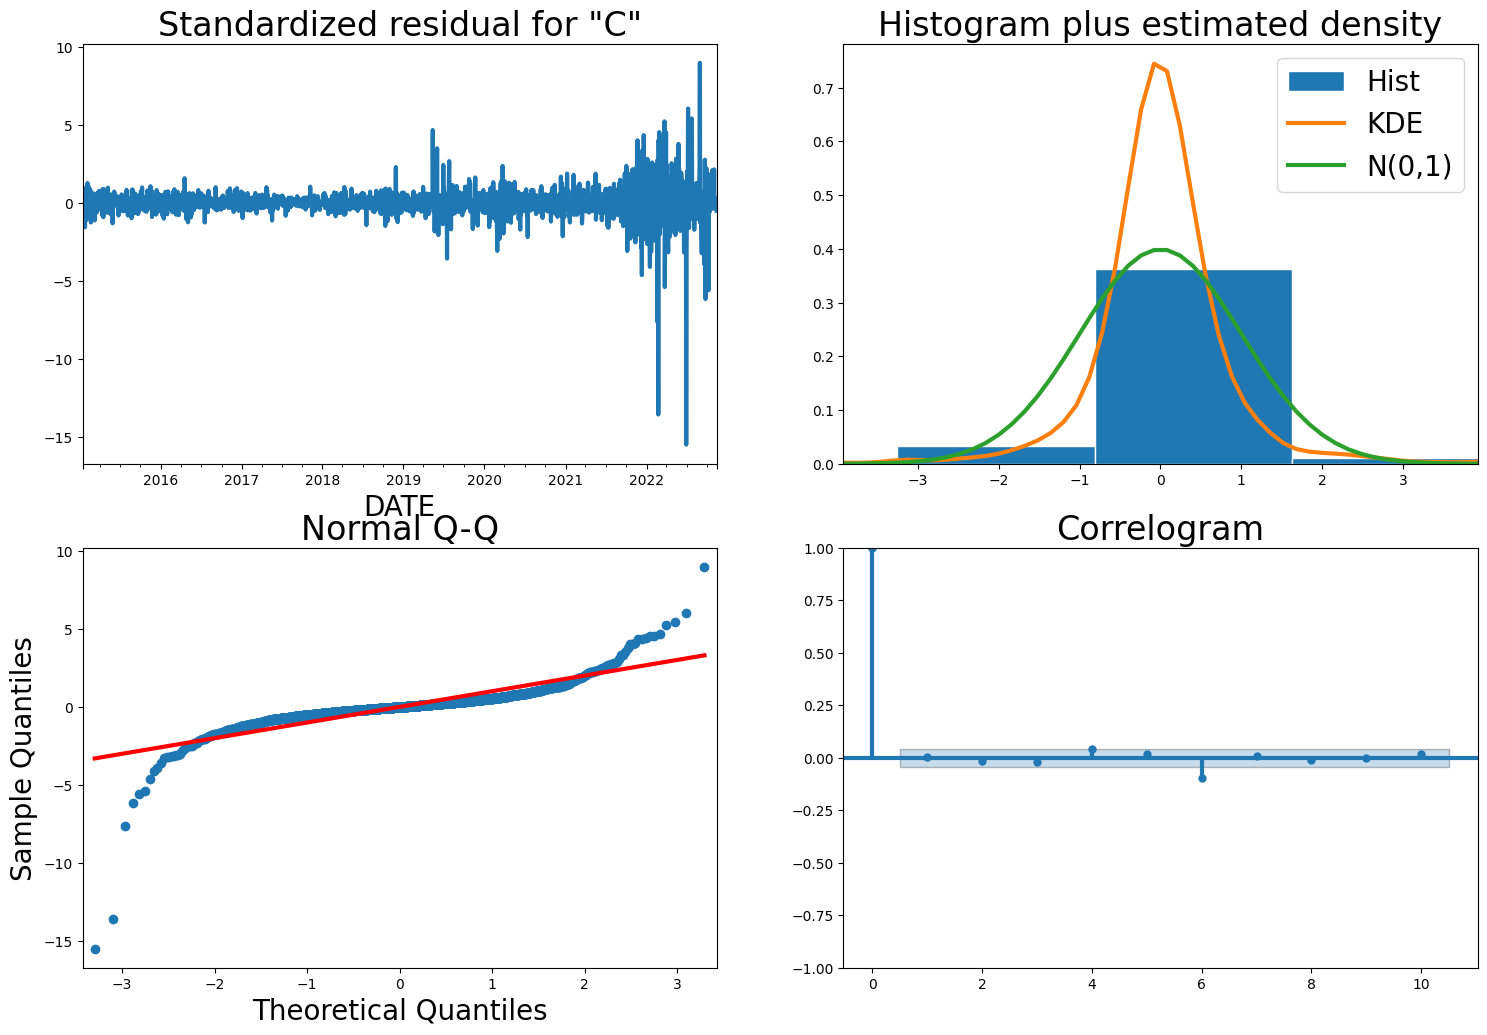

In [1775]:
model2_fit.plot_diagnostics(figsize=(18, 12))
plt.show()

*По графику видим, что данные  также распределены ненормально.*

Построим график предсказания

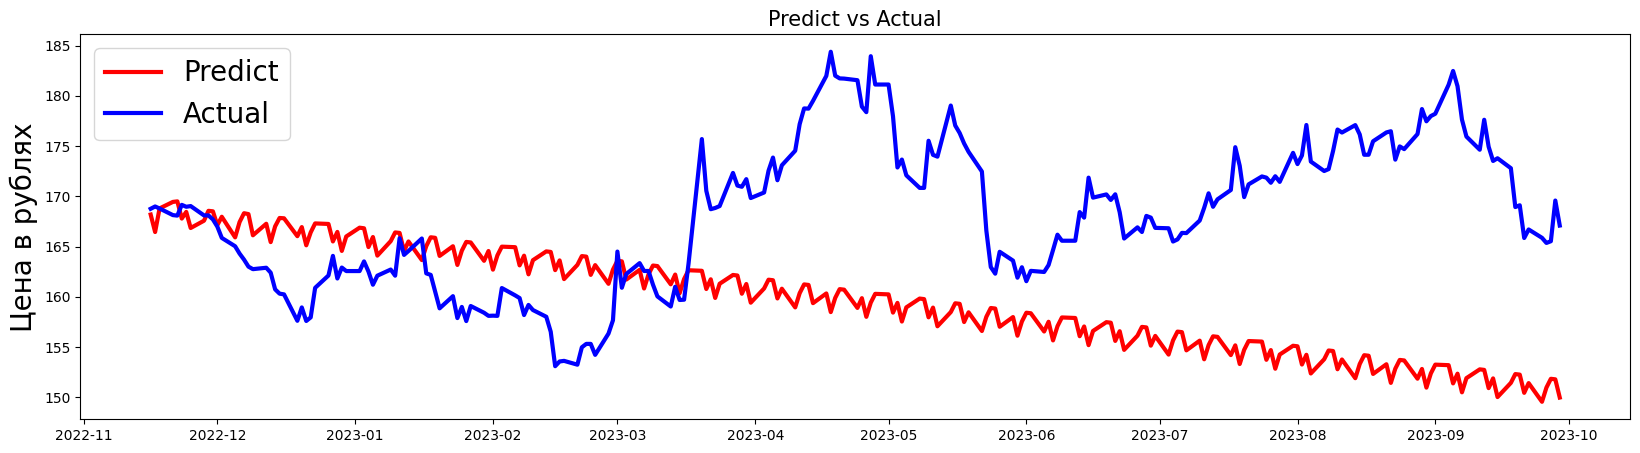

In [1776]:
start_date = '2022-11-16'
end_date = '2023-09-29'

df_pred2 = model2_fit.predict(start=start_date, end=end_date)

plt.figure(figsize=(20,5))
plt.plot(df_pred2, color="red", label="Predict")

plt.plot(test_df, color="blue", label="Actual") 

plt.title('Predict vs Actual', fontsize=15)
plt.ylabel('Цена в рублях')
plt.legend() 

plt.show()

*Уже по графику видно, что модель гораздо лучше справилась с предсказанием цен на акции Газпром. Но т.к. данная модель является довольно простой, она не показывает чередущиеся пики роста и падения, что может быть критично при торговле на бирже.*

Посчитаем метрики MAE, MSE и MAPE для сравнения моделей

In [1777]:
y_true = test_df.values
y_pred = df_pred2.values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 11.437


In [1778]:
np.sqrt(mean_squared_error(test_df, df_pred2))

13.82866260359857

In [1779]:
print(f"Results MAPE: {mean_absolute_percentage_error(test_df, df_pred2)*100:.1f}%")

Results MAPE: 6.7%


## Волатильность и модель GARCH

Посчитаем волатильность цен акций при закрытии биржы

In [1780]:
gzp_data["Close_vol"] = gzp_data.CLOSE.pct_change(1).mul(100).abs()
gzp_data["Close_vol"].head()

DATE
2015-01-05         NaN
2015-01-06    3.710340
2015-01-07    0.000000
2015-01-08    5.427584
2015-01-09    3.250034
Freq: B, Name: Close_vol, dtype: float64

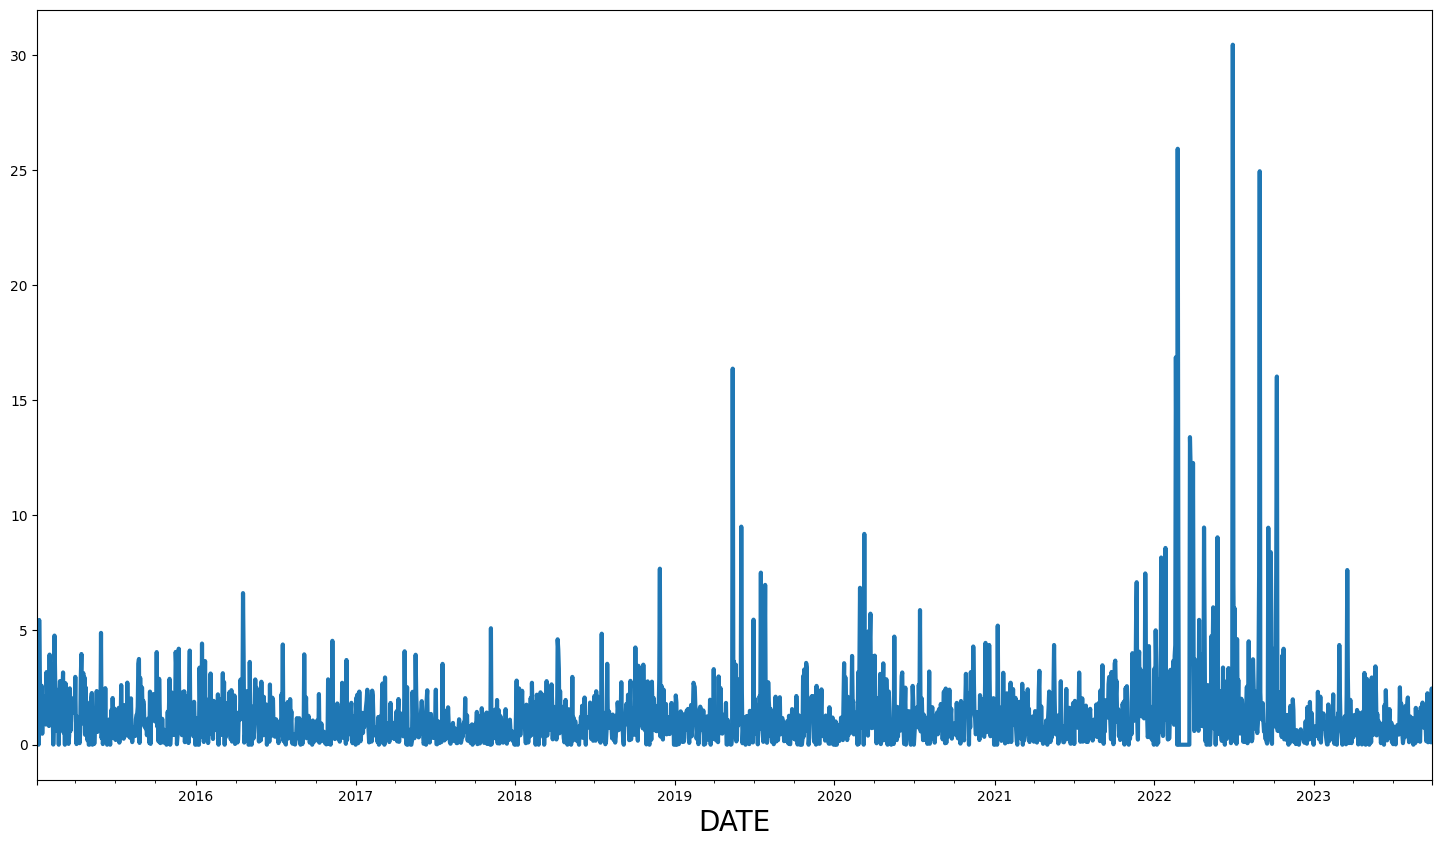

In [1781]:
# визуализируем данные
gzp_data["Close_vol"].plot()
plt.show()

*В среднем волатильность не поднимается выше 5, но наблюдаются несколько пиков роста,которые сомпадают с пиками роста акций при закрытии биржы.*

Повторно разделим ряд на тренировочный и тестовый в соотношении 80/20 и построим график частичной автокорреляции.

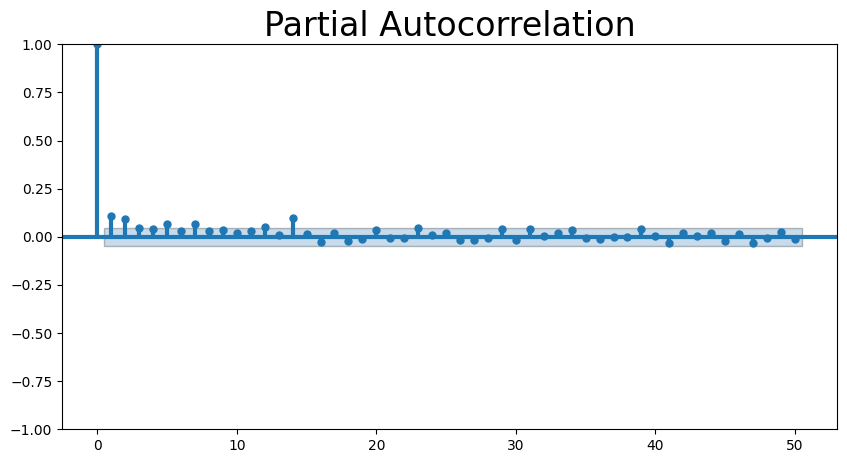

In [1782]:
size = int(len(gzp_data)*0.8)

train_vol = gzp_data.iloc[:size]
test_vol = gzp_data.iloc[size:]

plt.rcParams["figure.figsize"] = 10, 5

sm.graphics.tsa.plot_pacf(train_vol.Close_vol[1:], lags=50, method="ywm")
plt.show()

*По графику видим, что p = 1.*

Проверим ряд на стационарность при помощи теста Дики-Фуллера

In [1783]:
stat_test(train_vol.Close_vol[1:]) 

adf:  -7.815242079535475
p-value:  6.8980362651654225e-12
Critical values:  {'1%': -3.4339700129534423, '5%': -2.8631390341376393, '10%': -2.567621272963846}
единичных корней нет, ряд стационарен


Ряд стационарен, можем переходить к обучению

In [1784]:
garch_df = pd.DataFrame(gzp_data["Close_vol"].loc[gzp_data.index])
garch_df.loc[train_vol.index, "Close_vol"] = train_vol["Close_vol"].dropna()

In [1785]:
model = arch_model(garch_df["Close_vol"].dropna(), p=1, q=1)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_vol.index[0], update_freq=6)

Iteration:      6,   Func. Count:     42,   Neg. LLF: 2758.91390602555
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2758.31058665108
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11


In [1786]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Close_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2758.31
Distribution:                  Normal   AIC:                           5524.62
Method:            Maximum Likelihood   BIC:                           5546.65
                                        No. Observations:                 1823
Date:                Tue, Oct 31 2023   Df Residuals:                     1822
Time:                        18:34:11   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.0913  4.383e-02     24.898 7.857e-137 [  1.005,  1.177]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0897  8.330e-02      1.076      0.282 [-7.360e-02,  0.253]
alpha[1]       0.0424  3.301e-02      1.285      0.199 [-2.229e-02,  0.107]
beta[1]        0.8877  8.501e-02     10.441  1.609e-25    [  0.721,  1.054]
===========================================================================

Covariance estimator: robust
"""

Делаем предсказание и создаем для предсказания отдельный столбец

In [1787]:
predictions_df = test_vol.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_vol.index
]
predictions_df

CLOSE  Close_vol  Predictions
DATE                                      
2021-12-31  342.39   0.000000     1.649676
2022-01-03  353.73   3.312013     1.763163
2022-01-04  352.55   0.333588     1.679090
2022-01-05  335.00   4.978017     2.220827
2022-01-06  346.13   3.322388     2.272105
...            ...        ...          ...
2023-09-25  165.87   0.497900     0.983659
2023-09-26  165.36   0.307470     0.988871
2023-09-27  165.53   0.102806     1.008881
2023-09-28  169.58   2.446686     1.063114
2023-09-29  167.09   1.468334     1.039369

[456 rows x 3 columns]

Визуализируем данные. Для этого на одном графике нанесем реальные и предсказанные данные.

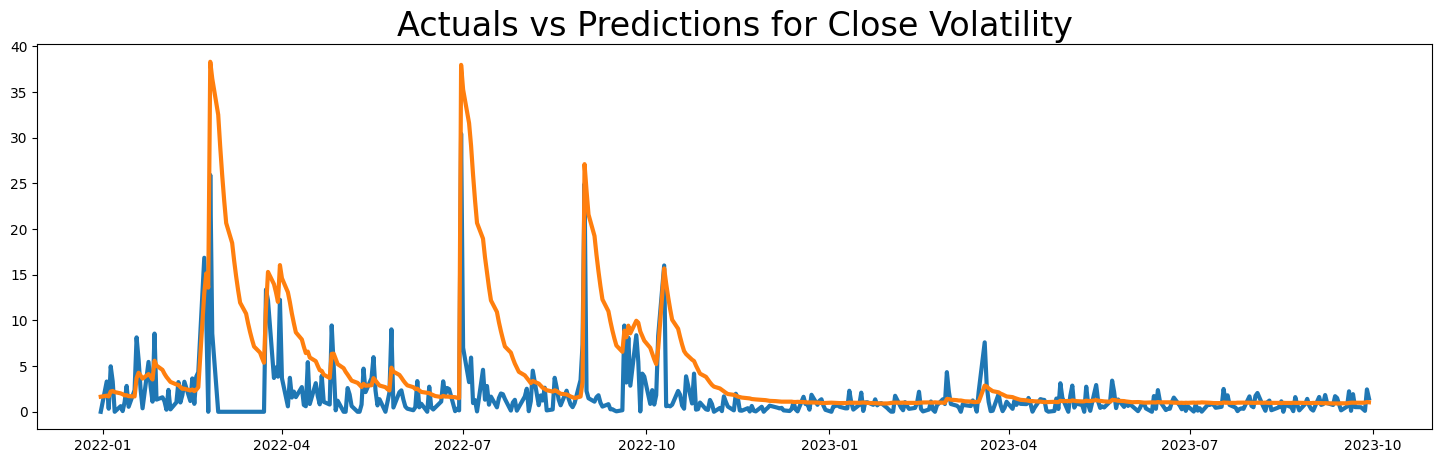

In [1788]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["Close_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for Close Volatility", size=24)

plt.show()

*Синим цветом нанесены реальные данные, оранжевым - предсказанные. По графику видим, что модель GARCH хорошо справилась с предсказанием.*

Посчитаем метрики MAE и MSE для сравнения моделей

In [1789]:
y_true = predictions_df["Close_vol"].values
y_pred = predictions_df["Predictions"].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 3.127


In [1790]:
np.sqrt(mean_squared_error(predictions_df["Close_vol"], predictions_df["Predictions"]))

6.010742688340528

#### Prophet

Повторно считаем датасет, т.к. нам требуются данные в формате датафрейма

In [1791]:
df = pd.read_csv('data/processed_data.csv')
df = df.drop(['OPEN', 'HIGH', 'LOW', 'VOLUME', 'Year', 'Month','Day', 'LEVEL', 'Is_quarter_end', 'Difference', 'Percent'], axis=1)

Переименуем столбцы

In [1792]:
df = df.rename(columns={'DATE': 'ds', 'CLOSE': 'y'})
df.head()

ds       y
0  2015-01-05  133.95
1  2015-01-06  138.92
2  2015-01-08  146.46
3  2015-01-09  141.70
4  2015-01-12  140.22

In [1793]:
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

Разделим выборки на тренировочную и тестовую. Для предсказания возьмем последние 200 дней, чтобы не попасть на самый пик

In [1794]:
test_length = 200
df_train = df.iloc[:-test_length]
df_test = df.iloc[-test_length:]

Создадим и обучим модель

In [1795]:
model = Prophet()
model.fit(df_train)

18:34:14 - cmdstanpy - INFO - Chain [1] start processing
18:34:15 - cmdstanpy - INFO - Chain [1] done processing


In [1796]:
future_df = model.make_future_dataframe(periods=test_length)

future_df.tail()

ds
2183 2023-06-29
2184 2023-06-30
2185 2023-07-01
2186 2023-07-02
2187 2023-07-03

Делаем предсказание

In [1797]:
forecast_df = model.predict(future_df)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2183 2023-06-29  182.893729  142.438864  220.712865
2184 2023-06-30  181.938268  143.271520  223.055583
2185 2023-07-01  170.676252  125.091340  213.293459
2186 2023-07-02  169.996701  128.566289  210.140327
2187 2023-07-03  179.255723  138.982028  221.656615

Визуализируем данные

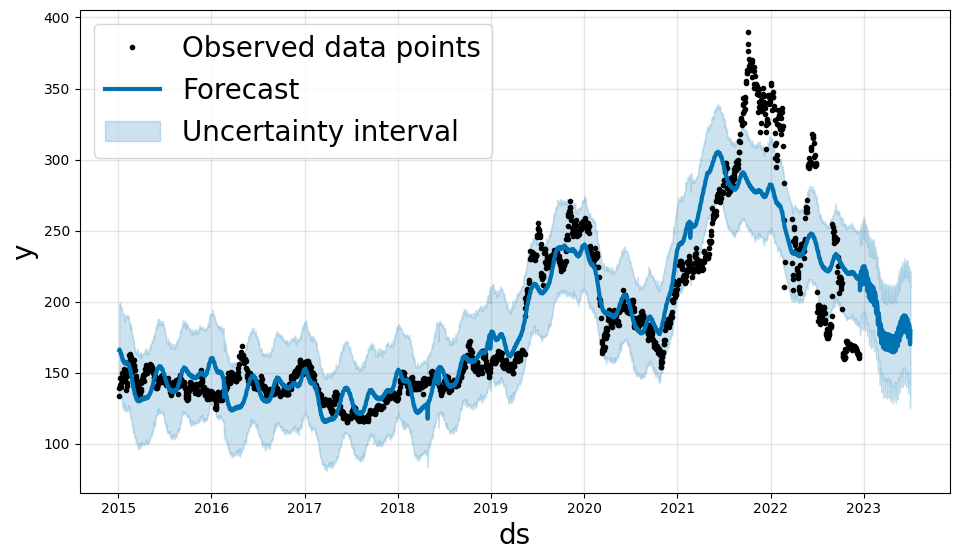

In [1798]:
fig = model.plot(forecast_df)
plt.legend()

Визуализируем компоненты

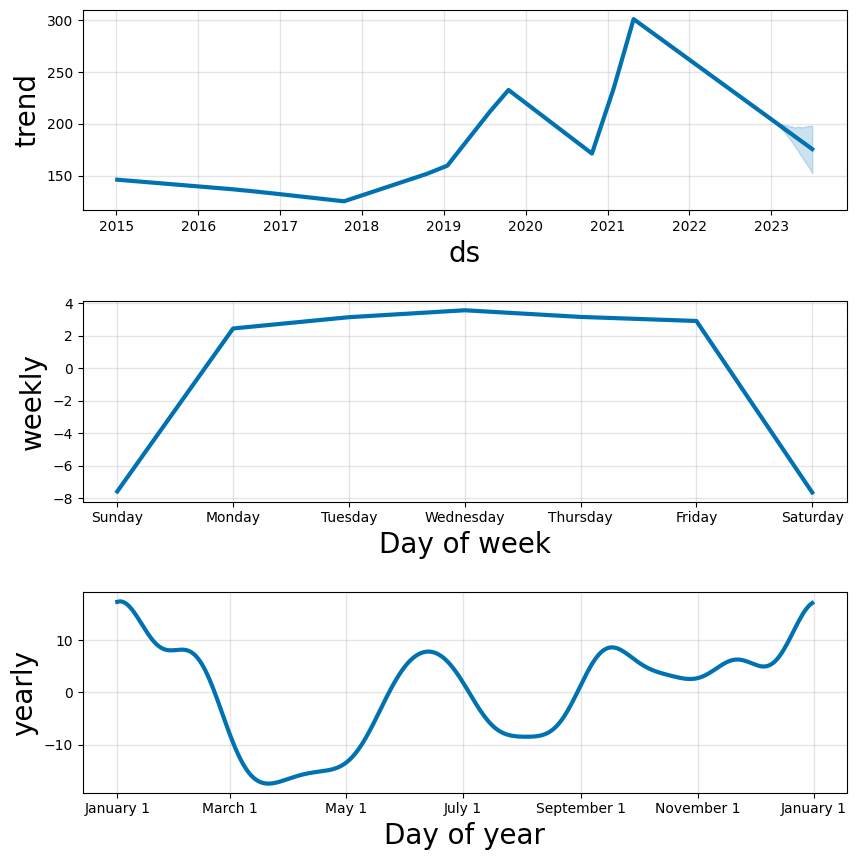

In [1799]:
fig = model.plot_components(forecast_df)

Посчитаем метрики MAE, MSE и MAPE для сравнения моделей

In [1800]:
# calculate MAE between expected and predicted values for december
y_true = df['y'].values
y_pred = forecast_df['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 18.156


In [1801]:
np.sqrt(mean_squared_error(y_true, y_pred))

25.597708160110464

In [1802]:
print(f"Results MAPE: {mean_absolute_percentage_error(y_true, y_pred)*100:.1f}%")

Results MAPE: 9.4%


#### NeuralProphet

Создадим и обучим модель

In [1803]:
# обучим модель используя NeuralProphet
nprophet_model = NeuralProphet()
metrics = nprophet_model.fit(df_train, freq="B")
future_df = nprophet_model.make_future_dataframe(df_train, 
                                                 periods = test_length, 
                                                 n_historic_predictions=len(df_train))
preds_df_2 = nprophet_model.predict(future_df)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.68% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 158
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (63) is too small than the required number for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.68% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Визуализируем данные

In [1804]:
nprophet_model.plot(preds_df_2)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~3D</i>',
              'type': 'scatter',
              'uid': '55f39bb1-6d22-490b-bd3d-bd93299d3e70',
              'x': array([datetime.datetime(2015, 1, 5, 0, 0),
                          datetime.datetime(2015, 1, 8, 0, 0),
                          datetime.datetime(2015, 1, 12, 0, 0), ...,
                          datetime.datetime(2023, 9, 15, 0, 0),
                          datetime.datetime(2023, 9, 20, 0, 0),
                          datetime.datetime(2023, 9, 21, 0, 0)], dtype=object),
              'y': array([162.72087097, 164.39328003, 164.58908081, ..., 260.68014526,
                          262.31704712, 261.21414185])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              

Визуализируем компоненты

In [1805]:
nprophet_model.plot_components(preds_df_2)

FigureWidgetResampler({
    'data': [{'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~3D</i>',
              'showlegend': False,
              'type': 'scatter',
              'uid': '6b3d8040-7d1c-46eb-ab49-21b0bfecdc27',
              'x': array([datetime.datetime(2015, 1, 5, 0, 0),
                          datetime.datetime(2015, 1, 6, 0, 0),
                          datetime.datetime(2015, 1, 9, 0, 0), ...,
                          datetime.datetime(2023, 9, 14, 0, 0),
                          datetime.datetime(2023, 9, 18, 0, 0),
                          datetime.datetime(2023, 9, 21, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([144.4335022 , 144.43902588, 144.45556641, ..., 261.45748901,
                          261.53720093, 261.59698486]),
              'yaxis': 'y'},
             {'line': {'color': '#2d92ff', 'width': 2},
  

In [1806]:
nprophet_model.plot_parameters()

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~3D</i>',
              'type': 'scatter',
              'uid': '4f1f910f-5054-4fdf-ac50-fdb96daa4697',
              'x': array([datetime.datetime(2015, 1, 5, 0, 0),
                          datetime.datetime(2015, 1, 7, 0, 0),
                          datetime.datetime(2015, 1, 8, 0, 0), ...,
                          datetime.datetime(2022, 12, 8, 0, 0),
                          datetime.datetime(2022, 12, 12, 0, 0),
                          datetime.datetime(2022, 12, 15, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([144.43350999, 144.44453719, 144.45005079, ..., 255.87775779,
                          255.95746828, 256.01725115]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
              '

Посчитаем метрики MAE, MSE и MAPE для сравнения моделей

In [1807]:
y_true = df['y'].values
y_pred = preds_df_2['yhat1'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 28.742


In [1808]:
np.sqrt(mean_squared_error(y_true, y_pred))

42.79289392595935

In [1809]:
print(f"Results MAPE: {mean_absolute_percentage_error(y_true, y_pred)*100:.1f}%")

Results MAPE: 15.1%


Сравним предсказания Prophet и NeuralProphet с реальными данными

<Axes: title={'center': 'Forecast evaluation'}, xlabel='ds'>

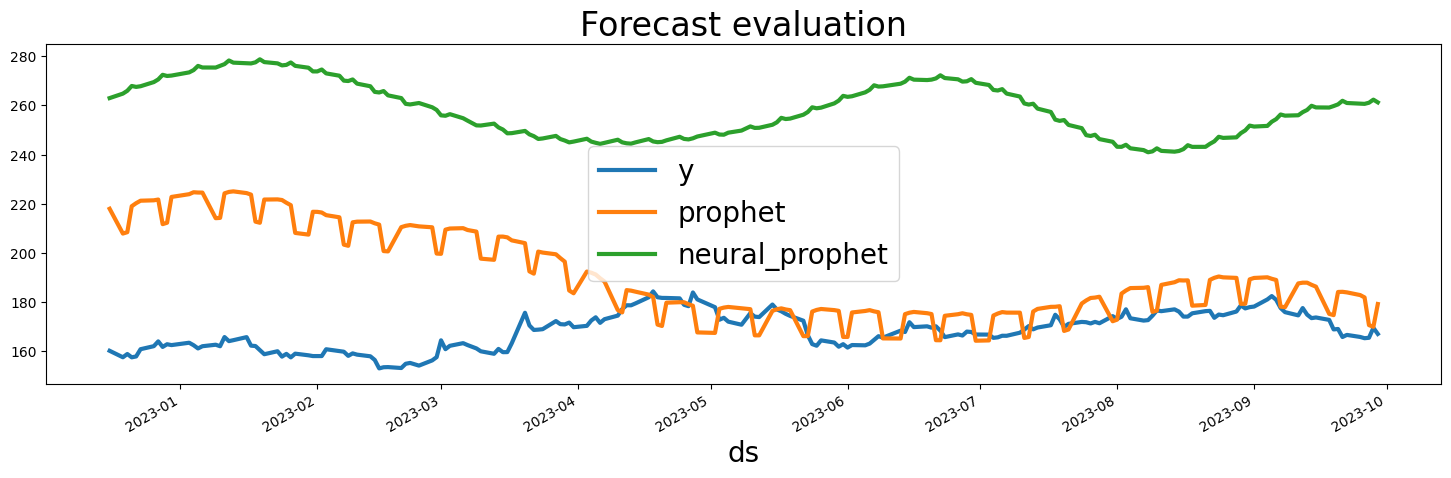

In [1810]:
df_test['prophet'] = forecast_df.iloc[-test_length:].loc[:, 'yhat']
df_test['neural_prophet'] = preds_df_2.iloc[-test_length:].loc[:, 'yhat1']
df_test.set_index('ds', inplace=True)

df_test.plot(title='Forecast evaluation')

*По графику видим, что Prophet лучше справился с предсказанием.*

## Вывод:
В результате проведенного обучения получили следующие метрики:
| Модель             | MAE                    | MSE           | MAPE          |
|--------------------|------------------------|---------------|---------------|
|ARIMA 1             |         286.8          |     315.2     |161 %          |
| ARIMA 2            |         11.44          |     13.83     |6.7 %          |
| Garch              |         3.13           |     6.01      | -             |
| Prophet            |         18.16          |     25.6      |9.4 %          |
| NeuralProphet      |         28.65          |     42.71     |15.1 %         |  

Самые лучшие показатели у модель GARCH, она дала лучший результат по метрикам и по графику предсказанные значения ближе всего находились к истинным. Но данная модель анализировала волатильность.

Если брать среди моделей, которые напрямую предсказывают цены на акции, лучшие метрики показала AutoArima при разделении тренировочной и тестовой выборок 90/10. На втором месте Prophet. Он показывает более низкие метрики, но процесс обучения модели проходит гораздо быстрее.

Для дальнейшего анализа рекомендовал бы взять данные за более длительный срок (например с 2000 - 2010 гг.), чтобы было больше данных для обучения и тестовая выборка не попадала на самый пик роста акций. Также можно взять почасовые данные. Кроме того можно подобрать экзогенные параметры и провести обучение методом SARIMAX.

Также стоит отметить, что алгоритмм анализа данных по акциям и построения прогноза ценна акций может использоваться для анализа любых акций с мминимальным изменением кода. Однако стоит учитывать, что модели дают предсказания, основываясь исключительно на математических методах анализа и не учитывают геополитические, экономические и иные факторы, которые могут оказать существенное влияние на изменение цен акций. Для проноза цен на акции необходимо проводить многофакторный анализ.

#### <center>Сохраним полученные моодели<center>

Сериализуем модель AUTO ARIMA 1 и сохраняем в файл формата `.pkl`.

In [1811]:
with open('ARIMA1.pkl', 'wb') as output:
    pickle.dump(df_pred, output)

Сериализуем модель AUTO ARIMA 2 и сохраняем в файл формата `.pkl`.

In [1812]:
with open('ARIMA2.pkl', 'wb') as output:
    pickle.dump(df_pred2, output)

Сериализуем модель GARCH и сохраняем в файл формата `.pkl`.

In [1813]:
with open('Garch.pkl', 'wb') as output:
    pickle.dump(model_results, output)

Сериализуем модель Prophet и сохраняем в файл формата `.pkl`.

In [1814]:
with open('Prophet.pkl', 'wb') as output:
    pickle.dump(forecast_df, output)

Сериализуем модель NeuralProphet и сохраняем в файл формата `.pkl`.

In [1815]:
with open('NProphet.pkl', 'wb') as output:
    pickle.dump([preds_df_2], output)

## <center>Дополнительные исследования<center>

### Дополнительно проведем предсказание по скользящему среднему

In [1816]:
data = pd.read_csv("data/processed_data.csv",parse_dates=['DATE'], index_col=['DATE']) # считываем датасет
data = data.drop(['Year', 'Month', 'Day', 'LEVEL', 'Is_quarter_end', 'Difference', 'Percent'], axis=1)
data

OPEN    HIGH     LOW   CLOSE    VOLUME
DATE                                                
2015-01-05  129.60  133.95  129.15  133.95  18208740
2015-01-06  132.99  138.92  132.71  138.92  25270920
2015-01-08  140.06  147.50  140.00  146.46  32544100
2015-01-09  146.46  147.08  139.90  141.70  29501280
2015-01-12  141.37  143.44  139.72  140.22  25286750
...            ...     ...     ...     ...       ...
2023-09-25  166.71  168.05  165.20  165.87  24208290
2023-09-26  165.83  165.85  163.51  165.36  26705860
2023-09-27  165.75  166.92  165.11  165.53  18500170
2023-09-28  165.81  169.77  165.31  169.58  28813860
2023-09-29  169.18  170.39  166.60  167.09  35820090

[2188 rows x 5 columns]

Shape of Training Set (1970, 1)
Shape of Validation Set (218, 1)
RMSE value on validation set: 53.83536692489104
-----------------------------------------------------------
-----------------------------------------------------------


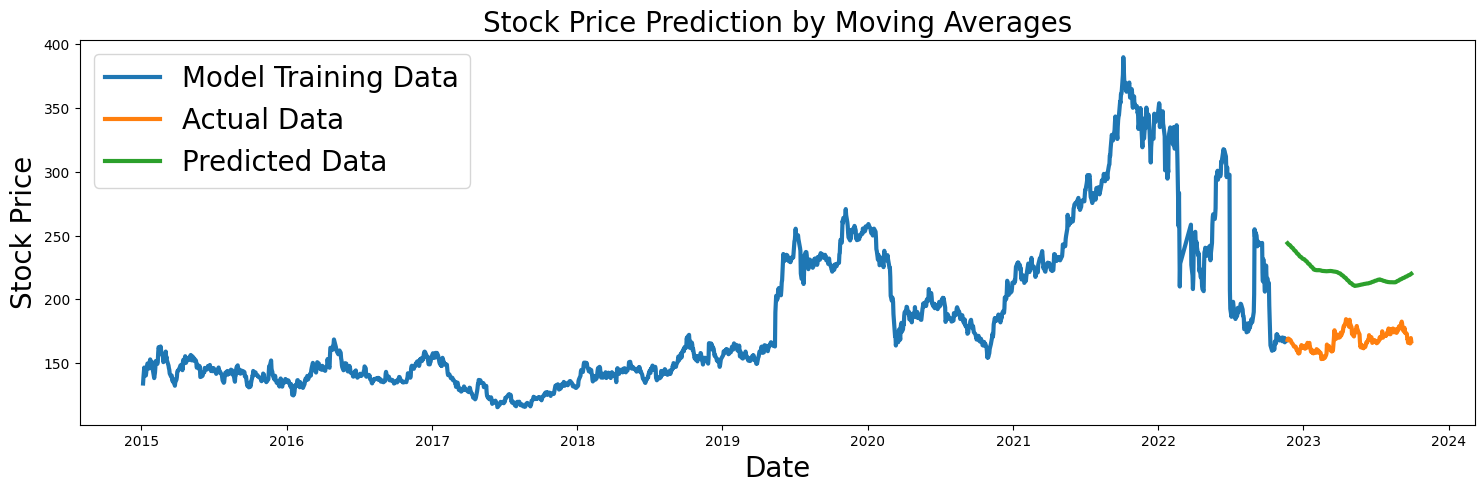

In [1817]:
from math import floor,ceil,sqrt
def moving_avg_prediction(df):
    shape=data.shape[0]
    df_new=data[['CLOSE']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.9)]
    valid_set=df_new.iloc[ceil(shape*0.9):]
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    preds = []
    for i in range(0,valid_set.shape[0]):
        a = train_set['CLOSE'][len(train_set)-valid_set.shape[0]+i:].sum() + sum(preds)
        b = a/(valid_set.shape[0])
        preds.append(b)
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['CLOSE'])-preds),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['CLOSE'])
    plt.plot(valid_set[['CLOSE', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Moving Averages',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    
moving_avg_prediction(data)

*По графику мы видим, что модель достаточно хорошо предсказывает общий тренд к падению цены акции с небольшими возрастаниями, но порядок цен намного выше реальных. Значит данную модель мы можем использоваться, чтобы предсказать тренд на акции (будет падение или возрастание), но при этом нельзя ее использовать для предсказания конкретного порядка цены.*

## Случайный лес

#### Дополнительно проведем исследования с помощью модели Случайного леса и посмотрим насколько верно она дает результат

Добавим столбец, с предсказанием на завтра

In [1818]:
data["Tomorrow"] = data["CLOSE"].shift(-1)

In [1819]:
data["Target"] = (data["Tomorrow"] > data["CLOSE"]).astype(int)
data

OPEN    HIGH     LOW   CLOSE    VOLUME  Tomorrow  Target
DATE                                                                  
2015-01-05  129.60  133.95  129.15  133.95  18208740    138.92       1
2015-01-06  132.99  138.92  132.71  138.92  25270920    146.46       1
2015-01-08  140.06  147.50  140.00  146.46  32544100    141.70       0
2015-01-09  146.46  147.08  139.90  141.70  29501280    140.22       0
2015-01-12  141.37  143.44  139.72  140.22  25286750    142.64       1
...            ...     ...     ...     ...       ...       ...     ...
2023-09-25  166.71  168.05  165.20  165.87  24208290    165.36       0
2023-09-26  165.83  165.85  163.51  165.36  26705860    165.53       1
2023-09-27  165.75  166.92  165.11  165.53  18500170    169.58       1
2023-09-28  165.81  169.77  165.31  169.58  28813860    167.09       0
2023-09-29  169.18  170.39  166.60  167.09  35820090       NaN       0

[2188 rows x 7 columns]

Обучим модель

In [1820]:
model = RandomForestClassifier(n_estimators=500, min_samples_split=100, random_state=1)

train = data.iloc[:-400]
test = data.iloc[-400:]

predictors = ["CLOSE", "VOLUME", "OPEN", "HIGH", "LOW"]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=500, random_state=1)

Сделаем предсказание и посмотри насколько точно модель предсказывает данные

In [1821]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4682926829268293

*Точность получилась всего 47%, т.е. модель чаще предсказывает неверный результат.*

<Axes: xlabel='DATE'>

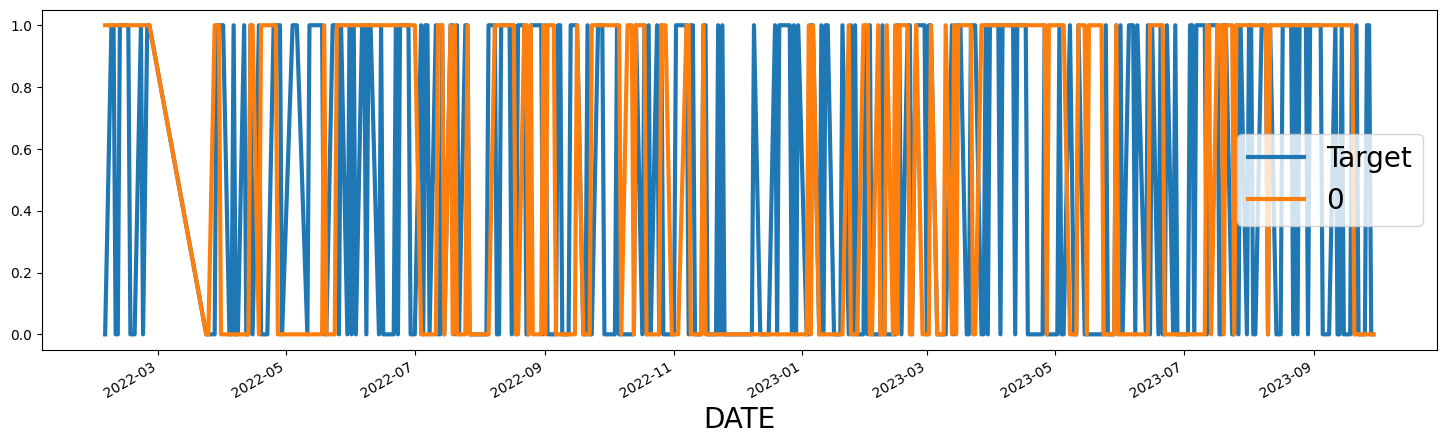

In [1822]:
#визуализируем точность предсказания
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [1823]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [1824]:
def backtest(data, model, predictors, start=500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [1825]:
predictions = backtest(data, model, predictors)

In [1826]:
predictions["Predictions"].value_counts()

0    931
1    757
Name: Predictions, dtype: int64

In [1827]:
precision_score(predictions["Target"], predictions["Predictions"])

0.47820343461030385

Добавим дополнительные данные для повышения качества обучения модели

In [1828]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["CLOSE"] / rolling_averages["CLOSE"]
    
    trend_column = f"Trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [1829]:
data = data.dropna(subset=data.columns[data.columns != "Tomorrow"])
data

OPEN    HIGH     LOW   CLOSE    VOLUME  Tomorrow  Target  \
DATE                                                                     
2018-12-20  150.23  152.38  149.70  152.27  27281980    151.12       0   
2018-12-21  151.41  152.27  150.32  151.12  24584730    149.73       0   
2018-12-24  150.66  151.15  148.93  149.73  10653140    147.01       0   
2018-12-25  148.36  148.49  145.02  147.01  13164880    148.41       1   
2018-12-26  147.47  149.66  147.36  148.41   8569530    150.68       1   
...            ...     ...     ...     ...       ...       ...     ...   
2023-09-25  166.71  168.05  165.20  165.87  24208290    165.36       0   
2023-09-26  165.83  165.85  163.51  165.36  26705860    165.53       1   
2023-09-27  165.75  166.92  165.11  165.53  18500170    169.58       1   
2023-09-28  165.81  169.77  165.31  169.58  28813860    167.09       0   
2023-09-29  169.18  170.39  166.60  167.09  35820090       NaN       0   

            Close_Ratio_2  Trend_2  Close_Ratio_5  Trend_5  Close_Ratio_60  \
DATE                                                                         
2018-12-20       0.997674      1.0       0.993839      1.0        0.960778   
2018-12-21       0.996209      0.0       0.991874      1.0        0.954594   
2018-12-24       0.995380      0.0       0.987678      1.0        0.947098   
2018-12-25       0.990834      0.0       0.976019      1.0        0.931354   
2018-12-26       1.004739      1.0       0.991330      1.0        0.941633   
...                   ...      ...            ...      ...             ...   
2023-09-25       0.997504      1.0       0.991500      2.0        0.957295   
2023-09-26       0.998460      0.0       0.992688      2.0        0.954364   
2023-09-27       1.000514      1.0       0.997998      2.0        0.955362   
2023-09-28       1.012086      2.0       1.017838      3.0        0.978434   
2023-09-29       0.992604      1.0       1.002424      2.0        0.963997   

            Trend_60  Close_Ratio_250  Trend_250  Close_Ratio_1000  Trend_1000  
DATE                                                                            
2018-12-20      29.0         1.034975      122.0          1.083067       472.0  
2018-12-21      28.0         1.026596      122.0          1.074794       471.0  
2018-12-24      27.0         1.016623      122.0          1.064883       470.0  
2018-12-25      27.0         0.997708      122.0          1.045499       470.0  
2018-12-26      27.0         1.006766      122.0          1.055394       471.0  
...              ...              ...        ...               ...         ...  
2023-09-25      32.0         0.981450      109.0          0.740730       487.0  
2023-09-26      32.0         0.979646      109.0          0.738674       487.0  
2023-09-27      32.0         0.981824      110.0          0.739663       487.0  
2023-09-28      32.0         1.006828      111.0          0.757977       488.0  
2023-09-29      32.0         0.993034      111.0          0.747069       488.0  

[1188 rows x 17 columns]

Повторно обучим модель на новых данных

In [1830]:
model = RandomForestClassifier(n_estimators=500, min_samples_split=100, random_state=1)

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [1831]:
predictions = backtest(data, model, new_predictors)
predictions["Predictions"].value_counts()

0.0    624
1.0     64
Name: Predictions, dtype: int64

In [1832]:
precision_score(predictions["Target"], predictions["Predictions"])

0.546875

*Получили процент верного предсказания почти 55 %, что уже значительно лучше, т.к. модель чаще дает верный прогноз, чем неверный.*